# Прогноз стоимости подержанных автомобилей

## Содержание

**[Описание](#0)**

- **[Описание проекта](#0)**

- **[Описание данных](#0_1)**

**[1. Обзор данных](#1)**

- **[1.1 Установка и импорт библиотек](#1_1)**
- **[1.2 Разведочный анализ данных](#1_2)**
- **[1.3 Общие выводы по качеству имеющихся данных](#1_3)**


**[2. Подготовка данных](#2)**

- **[2.1. Предобработка данных](#2_1)**
- **[2.2. Проверка данных на мультиколлинеарность](#2_2)**
- **[2.3. Общие выводы по подготовке данных ](#2_3)**


**[3. Обучение моделей](#3)**

- **[3.1. Пробразование категорий в число](#3_1)**
- **[3.2. Проверка метода word_str. Объединение значений символов](#3_2)**
- **[3.3. Проверка метода word_int. Сумма значений символов](#3_3)**
- **[3.4. Модель линейной регрессии](#3_4)**
- **[3.5. Модель Решающего дерева](#3_5)**
- **[3.6. Методы улучшения качества моделей](#3_6)**
- **[3.7. Общие выводы](#3_7)**


**[4. Подготовка контрольного датасета](#4)**

## Описание проекта <a id='0'></a>

**Соревнование на платформе Kaggle.** **[Предсказание стоимости автомобиля на вторичном рынке.](https://www.kaggle.com/competitions/used-cars-price-prediction-22ds/overview)**

**Цель Соревнования.** Разработка модели, которая достигнет наилучшего значения показателя `MAPE` (Mean Absolute Percentage Error).

**Цель исследования.** Исследовать зависимость стоимости автомобиля от различных характеристик и построить модель для определения стоимости автомобиля с высоким качеством предсказания.

**План:**
- **1.** Провести обзор данных.
    - Выгрузка
    - Первичный обзор с помощью библиотеки skim
    - Первые выводы
- **2.** Провести первичную предобработку и  исследовательский анализ данных.
   + Посмотреть на распределения признаков.
   + Посмотреть как целевой признак зависит от остальных.
   + Изучить корреляции признаков с целевым и между собой.
- **3.** Первчиная предобработка:
    - Проверить дубликаты
    - Заполнить пропуски 
    - Обработать редкие и аномальные значения
- **4.** Подготовить данные для обучения
  + Удалить лишние признаки
  + Создать синтетические признаки (`Feature Engineering`)
  + Разбить на тестовую и обучающую выборки
  + Подготовить pipeline с кодировщиками и scaler'ами
- **5.** Обучить модели и выбрать лучшую
  - Обучить несколько моделей с помощью `Optuna`
  - Выбрать лучшую по метрике `MAPE`
- **6.** Протестировать выбранную модель 
  - Достичь показателя `MAPE` менее `20%`
  - Проверить модель на адекватность
  - Вывести график важности признаков
  - Загрузить модель на kaggle


**Входные данные.** Три файла в формате `.csv` с данными о продаваемых машинах:
1. `train.csv` - информация о характеристиках автомобилей (~440000), которые будут использоваться в качестве обучающих данных.
2. `test.csv` - информация о характеристиках автомобилей (~110000), которые будут использоваться в качестве тестовых данных.
3. `sample_submission.csv` - пример файла предсказаний в правильном формате.

**Формальная задача.** Предсказать значение `'sellingprice'` для каждого автомобиля из датасета `test.csv`.

**Ожидаемый результат.** Построена модель для определения стоимости автомобиля, со значением метрики `MAPE` менее **20**.

[def]: 'https://www.kaggle.com/competitions/used-cars-price-prediction-22ds/overview'

## Описание данных <a id ='0_1'></a>

**Признаки**

- `year` – год выпуска автомобиля.
- `make` – марка автомобиля.
- `model` – модель автомобиля определенной марки.
- `trim` – уровень отделки салона автомобиля.
- `body` – тип кузова транспортного средства.
- `transmission` – тип коробки передач.
- `vin` – идентификационный номер транспортного средства.
- `state` – состояние, в котором автомобиль выставлен на аукцион.
- `condition` – оценка состояние автомобилей на момент аукциона.
- `odometer` – расстояние, пройденное автомобилем с момента выпуска.
- `color` – цвет кузова автомобиля.
- `interior` – цвет салона автомобиля.
- `seller` – продавец автомобиля, автосалоны.
- `saledate` – дата продажи автомобиля. 

**Целевой признак**

- `sellingprice` – цена, по которой автомобиль был продан на аукционе.

***Примичание***

- После проведения разведочного анализа, выяснилось, что в `state` находить штат (регион), а не состояние автомобиля.

## Импорты

In [ ]:
from IPython.display import clear_output
%pip install skimpy
%pip install --user linear-tree
%pip install --upgrade pip
%pip install --user --upgrade Pillow
%pip install --upgrade matplotlib
%pip install ydata_profiling
%pip install optuna
%pip install vininfo
%pip install retrying
clear_output()

In [2]:
import pandas as pd
import numpy as np
import math

from ydata_profiling import ProfileReport
from skimpy import skim

import sys
import time
import requests
from retrying import retry
from tqdm import tqdm
from datetime import datetime
from vininfo import Vin


from IPython.display import Markdown
import nbformat

import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import Pool, CatBoostRegressor, CatBoostClassifier, cv

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
# plt.style.use('default') 
sns.set_style("dark")
plt.style.use('dark_background') # я работаю в темной теме, поэтому использую эту настройку.
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

s = 42

## Обзор данных <a id='1'></a>

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

dfs = [train, test]
dfs_names = ['train', 'test']
cat_cols = ['make', 'model', 'trim', 'body', 'transmission','state','color','interior','seller']

In [3]:
train['saledate'] = pd.to_datetime(pd.to_datetime(train['saledate'], utc=True).dt.date)
test['saledate'] = pd.to_datetime(pd.to_datetime(test['saledate'], utc=True).dt.date)

test['year'] = pd.to_datetime(test['year'],format='%Y')
train['year'] = pd.to_datetime(train['year'],format='%Y')

test['lifetime'] = (test['saledate'] - pd.to_datetime(train['year'], format='%Y-%m-%d')).dt.days
train['lifetime'] = (train['saledate'] - pd.to_datetime(train['year'], format='%Y-%m-%d')).dt.days

In [4]:
for i in range(len(dfs)):
    df = dfs[i]
    df['saledate'] = pd.to_datetime(pd.to_datetime(df['saledate'], utc=True).dt.date)
    df['year'] = pd.to_datetime(df['year'],format='%Y')
    df['lifetime'] = np.abs((df['saledate'] - pd.to_datetime(df['year'], format='%Y-%m-%d'))).dt.days
    df['km/day'] = np.where(df['lifetime'] == 0, 0, np.abs(df['odometer'] / df['lifetime']))

In [5]:
for i in range(len(dfs)):
    display(skim(dfs[i]))

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 440236 │ │ string      │ 10    │                                                          │
│ │ Number of columns │ 17     │ │ float64     │ 3     │                                                          │
│ └───────────────────┴────────┘ │ datetime64  │ 2     │                                                          │
│                                │ int32       │ 2     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name    ┃ NA    ┃ NA %                   ┃ mean   ┃ sd     ┃ p0  ┃ p25   ┃ p75   ┃ p100    ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩  │
│ │ condition      │  9405 │      2.136354137326343 │    3.4 │   0.95 │   1 │   2.7 │   4.2 │       5 │  ▄▄▅█▅ │  │
│ │ odometer       │    69 │   0.015673411533813682 │  68000 │  54000 │   1 │ 28000 │ 99000 │ 1000000 │   █    │  │
│ │ sellingprice   │     0 │                      0 │  14000 │   9800 │   1 │  6900 │ 18000 │  230000 │   █    │  │
│ │ lifetime       │     0 │                      0 │   1900 │   1400 │   0 │   780 │  2900 │   12000 │  █▃▁   │  │
│ │ km/day         │    69 │   0.015673411533813682 │     45 │    130 │   0 │    26 │    51 │   27000 │   █    │  │
│ └────────────────┴───────┴────────────────────────┴────────┴────────┴─────┴───────┴───────┴─────────┴────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name            ┃ NA     ┃ NA %      ┃ first               ┃ last                ┃ frequency        ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩  │
│ │ year                   │      0 │         0 │     1982-01-01      │     2015-01-01      │ None             │  │
│ │ saledate               │      0 │         0 │     2014-01-01      │     2015-07-20      │ None             │  │
│ └────────────────────────┴────────┴───────────┴─────────────────────┴─────────────────────┴──────────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name          ┃ NA        ┃ NA %                         ┃ words per row        ┃ total words       ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩  │
│ │ make                 │      8043 │           1.8269746227023687 │                 0.99 │            433689 │  │
│ │ model                │      8123 │            1.845146694045921 │                 0.99 │            433689 │  │
│ │ trim                 │      8337 │           1.8937569848899227 │                 0.99 │            433689 │  │
│ │ body                 │     10393 │           2.36077

None

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 110058 │ │ string      │ 10    │                                                          │
│ │ Number of columns │ 16     │ │ float64     │ 4     │                                                          │
│ └───────────────────┴────────┘ │ datetime64  │ 2     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name   ┃ NA    ┃ NA %                   ┃ mean   ┃ sd     ┃ p0  ┃ p25    ┃ p75   ┃ p100    ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩  │
│ │ condition     │  2379 │      2.161587526576896 │    3.4 │   0.95 │   1 │    2.7 │   4.2 │       5 │  ▄▅▆█▅ │  │
│ │ odometer      │    19 │   0.017263624634283742 │  68000 │  54000 │   1 │  28000 │ 99000 │ 1000000 │   █    │  │
│ │ lifetime      │     0 │                      0 │   1900 │   1500 │   0 │    770 │  2900 │   12000 │  █▃▁   │  │
│ │ km/day        │    19 │   0.017263624634283742 │    130 │   2000 │   0 │     16 │    84 │  380000 │   █    │  │
│ └───────────────┴───────┴────────────────────────┴────────┴────────┴─────┴────────┴───────┴─────────┴────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name            ┃ NA     ┃ NA %      ┃ first               ┃ last                ┃ frequency        ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩  │
│ │ year                   │      0 │         0 │     1982-01-01      │     2015-01-01      │ None             │  │
│ │ saledate               │      0 │         0 │     2014-01-01      │     2015-07-13      │ None             │  │
│ └────────────────────────┴────────┴───────────┴─────────────────────┴─────────────────────┴──────────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name         ┃ NA        ┃ NA %                          ┃ words per row        ┃ total words       ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩  │
│ │ make                │      2061 │            1.8726489669083575 │                 0.98 │            108365 │  │
│ │ model               │      2079 │            1.8890039797197842 │                 0.98 │            108365 │  │
│ │ trim                │      2114 │            1.9208053935197804 │                 0.98 │            108365 │  │
│ │ body                │      2594 │             2.356939068491159 │                 0.98 │            108365 │  │
│ │ transmission        │     13011 │            11.821948427192934 │                 0.98 │            108365 │  │
│ │ vin                 │         0 │                   

None

In [96]:
# @retry(wait_fixed=10_000, stop_max_attempt_number=3)
# def get_vehicle_info(vin):
#     url = f"https://vpic.nhtsa.dot.gov/api/vehicles/DecodeVinValues/{vin}?format=json"
#     response = requests.get(url)
#     data = response.json()

#     if "Results" in data:
#         results = data["Results"]
#         if results:
#             vehicle_info = {
#                 "body": results[0]["BodyClass"],
#                 "model": results[0]["Model"],
#                 "make": results[0]["Make"],
#                 "transmission": results[0]["TransmissionStyle"],
#                 "trim": results[0]["Trim"]
#             }
#             return vehicle_info

#     return None

# def vin_fillna(data):
#     for index, row in tqdm(data.iterrows(), total=len(data)):
#         vin = row["vin"]  

#         if (pd.isnull(row["body"]) 
#             or pd.isnull(row["model"]) 
#             or pd.isnull(row["make"]) 
#             # or pd.isnull(row["transmission"]) 
#             or pd.isnull(row["trim"])):
#             try:
#                 vehicle_info = get_vehicle_info(vin)
#             except Exception as e:
#                 print(f"An error occurred: {e}")
#                 continue

#             if vehicle_info:
#                 data.at[index, "body"] = vehicle_info.get("body", np.nan)
#                 data.at[index, "model"] = vehicle_info.get("model", np.nan)
#                 data.at[index, "make"] = vehicle_info.get("make", np.nan)
#                 # data.at[index, "transmission"] = vehicle_info.get("transmission", np.nan)
#                 data.at[index, "trim"] = vehicle_info.get("trim", np.nan)


In [97]:
# vin_fillna(train)

  0%|          | 0/440236 [00:00<?, ?it/s]

100%|██████████| 440236/440236 [2:35:54<00:00, 47.06it/s]   


2226 30

In [98]:
# vin_fillna(test)

100%|██████████| 110058/110058 [50:08<00:00, 36.58it/s] 


In [146]:
test = test.drop('saledate',axis=1)
train = train.drop('saledate',axis=1)
train[cat_cols] = train[cat_cols].apply(lambda x: x.str.lower())
test[cat_cols] = test[cat_cols].apply(lambda x: x.str.lower())
test['year'] = pd.to_datetime(test['year']).dt.year
train['year'] = pd.to_datetime(train['year']).dt.year
train.to_csv('train_filled.csv',index=False)
test.to_csv('test_filled.csv',index=False)

In [4]:
train = pd.read_csv('train_filled.csv')
test = pd.read_csv('test_filled.csv')

In [5]:
train['saledate'] = pd.read_csv('train.csv')['saledate']
test['saledate'] = pd.read_csv('test.csv')['saledate']

In [6]:
cols = ['make', 'model', 'trim', 'body', 'transmission', 'vin', 'state','color', 'interior', 'seller']

train[cols] = train[cols].apply(lambda x: x.str.lower())
test[cols] = test[cols].apply(lambda x: x.str.lower())

In [7]:
train['transmission'].value_counts()

transmission
automatic                                   375049
manual                                       13711
continuously variable transmission (cvt)         2
manual/standard                                  1
Name: count, dtype: int64

In [8]:
test['transmission'].value_counts()

transmission
automatic    93584
manual        3463
Name: count, dtype: int64

In [9]:
train['transmission'] = train['transmission'].replace(['continuously variable transmission (cvt)', 'manual/standard'], 'manual')

In [10]:
dfs = [train, test]
for i in range(len(dfs)):
    df = dfs[i]
    df['saledate'] = pd.to_datetime(pd.to_datetime(df['saledate'], utc=True).dt.date)
    df['year'] = pd.to_datetime(df['year'],format='%Y')
    df['lifetime'] = np.abs((df['saledate'] - pd.to_datetime(df['year'], format='%Y-%m-%d'))).dt.days
    df['km/day'] = np.where(df['lifetime'] == 0, 0, np.abs(df['odometer'] / df['lifetime']))

In [11]:
target = 'condition'
cat_cols = ['make', 'model', 'trim', 'body','state','color','interior','seller']
num_cols = list(test.columns.drop(cat_cols+['vin']+[target]+['transmission']))
features = cat_cols + num_cols

train[cat_cols] = train[cat_cols].fillna('unknown')
train[num_cols] = train[num_cols].fillna(train[num_cols].median())

test[cat_cols] = test[cat_cols].fillna('unknown')
test[num_cols] = test[num_cols].fillna(train[num_cols].median())

valid_condition = train[train[target].isna()==False].copy()
pred_condition = train[train[target].isna()==True].copy()

In [13]:
def km_day_normilaze(df, km_day_cup=1800, lifetime_cup = False):

    if lifetime_cup == False:
        new_values = df.loc[df['km/day'] > km_day_cup, 'odometer'] / (df.loc[df['km/day'] > km_day_cup, 'lifetime'] + 365)
        df.loc[df['km/day'] > km_day_cup, 'lifetime'] += 365
        df.loc[df['km/day'] > km_day_cup, 'km/day'] = new_values

    else:
        new_values = (df.loc[(df['km/day']) > km_day_cup & (df['lifetime'] < lifetime_cup), 'odometer'] /
            (df.loc[(df['km/day']) > km_day_cup & (df['lifetime'] < lifetime_cup), 'lifetime'] + 365))

        df.loc[(df['km/day']) > km_day_cup & (df['lifetime'] < lifetime_cup), 'lifetime'] += 365
        df.loc[(df['km/day']) > km_day_cup & (df['lifetime'] < lifetime_cup), 'km/day'] = new_values

In [14]:
km_day_normilaze(test)
km_day_normilaze(test,200)
km_day_normilaze(train)
km_day_normilaze(train,200)

In [15]:
col = 'km/day'
display(train[col].sort_values().head(5))
display(train[col].sort_values().tail(5))
display(f'Среднее: {train[col].mean()}, Медиана: {train[col].median()}')

352181    0.0
2180      0.0
436660    0.0
409159    0.0
49792     0.0
Name: km/day, dtype: float64

394885    892.856250
342379    893.654155
160641    904.158228
150893    904.158228
288664    909.090000
Name: km/day, dtype: float64

'Среднее: 40.59701101354006, Медиана: 36.10353054556566'

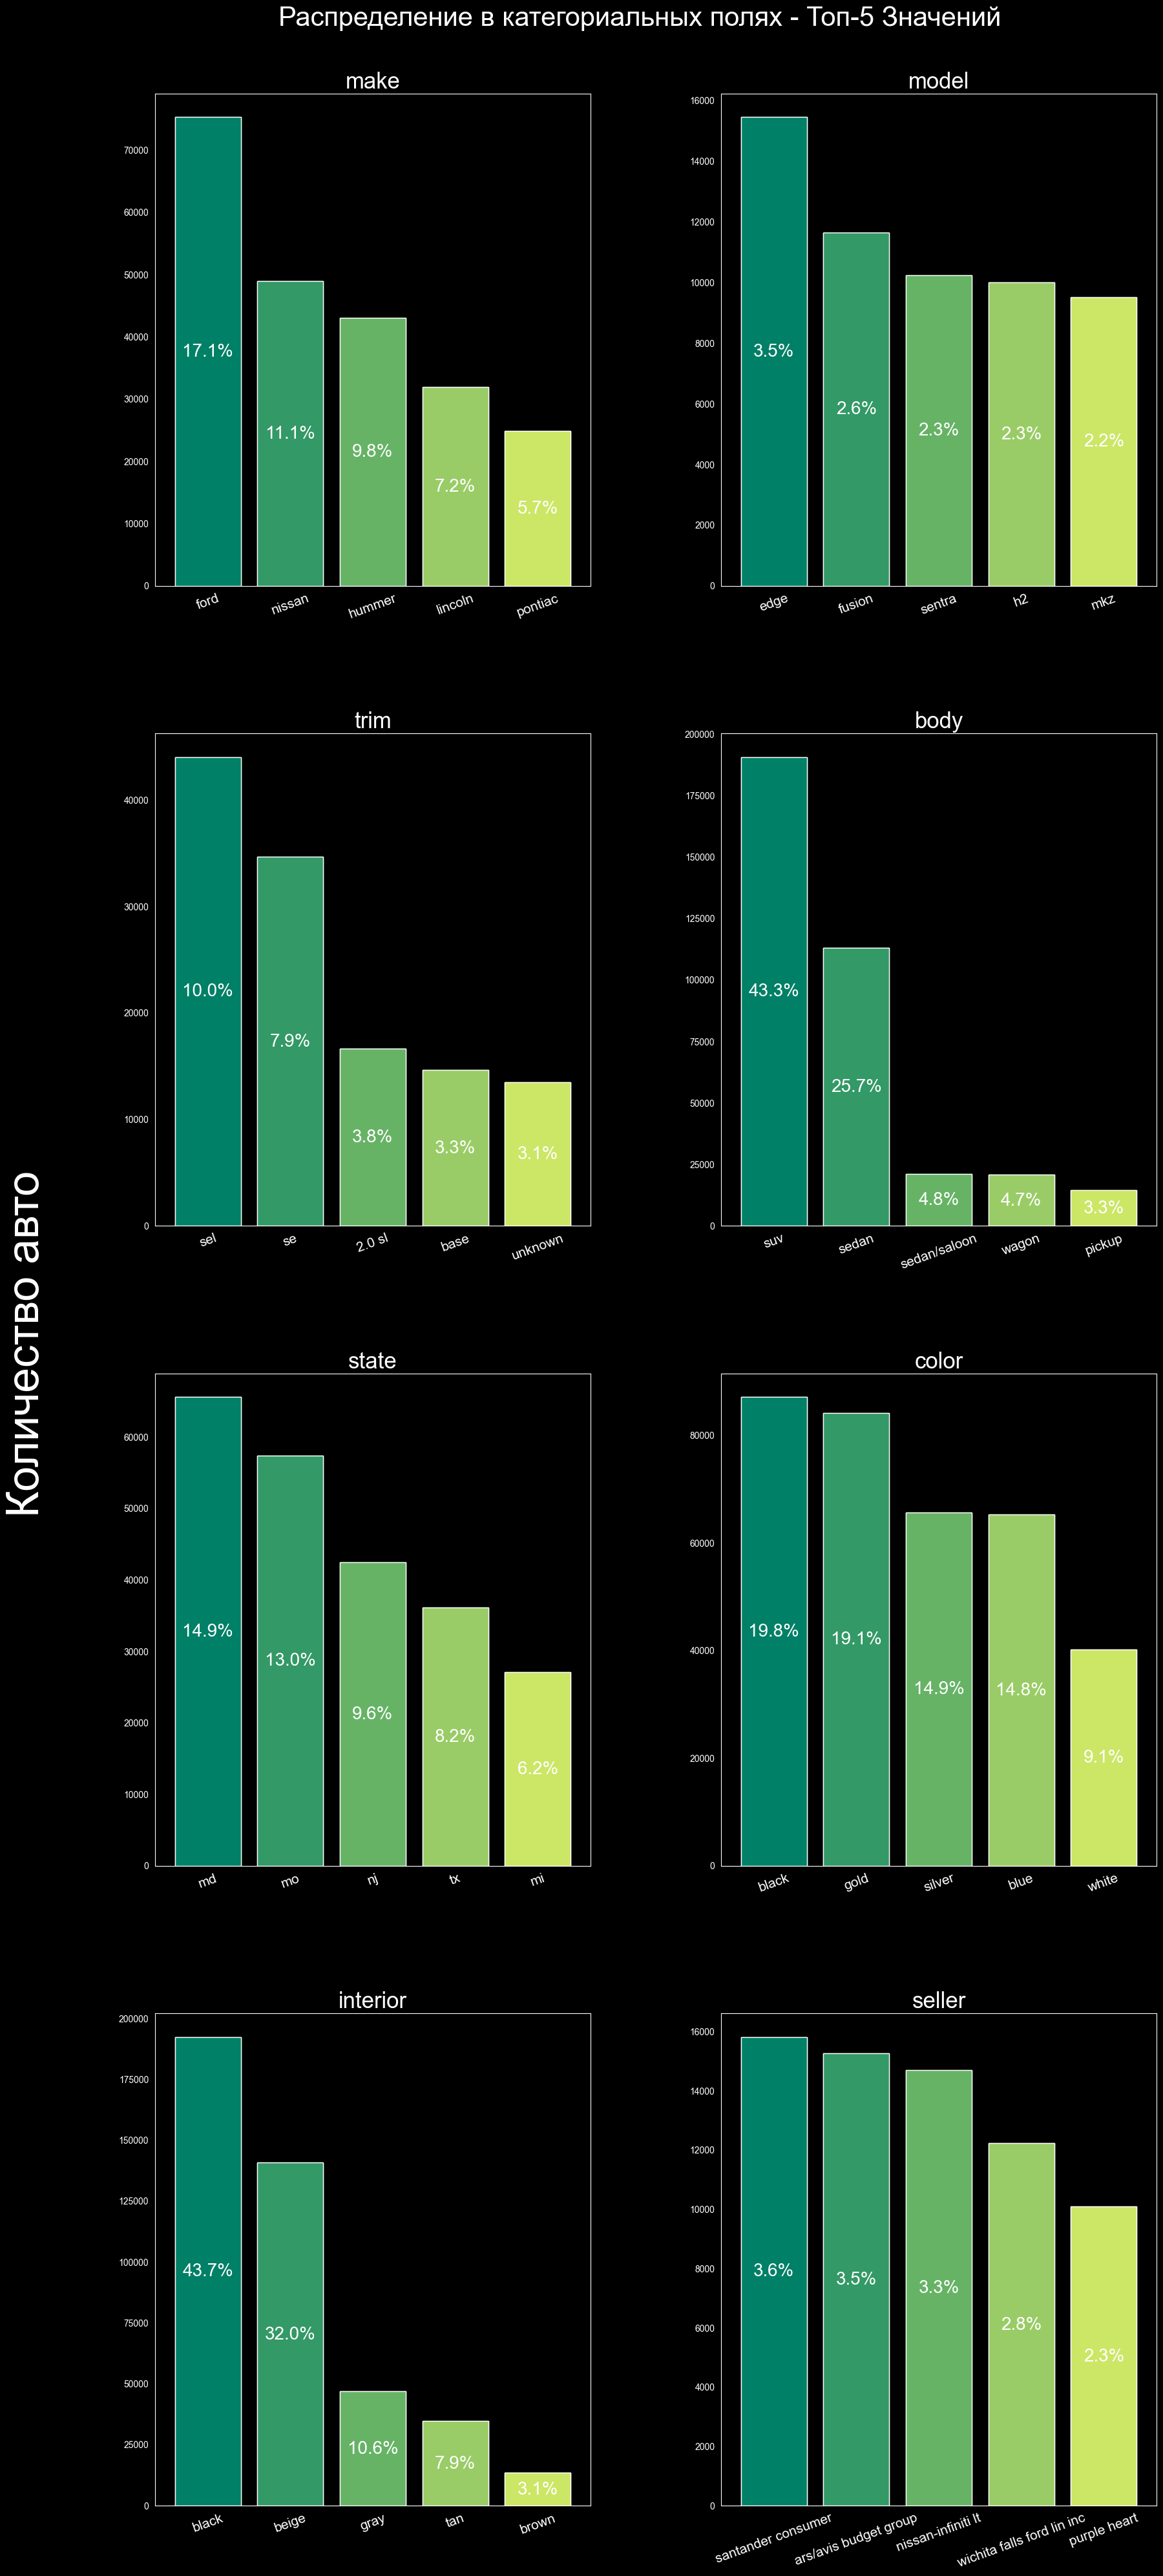

In [16]:

df = train.copy()

palette = plt.cm.summer
fig = plt.figure()
plot_num = 1
fig.text(0.01, 0.75, 'Количество авто', va='center', rotation='vertical', size=50) 

# цикл по столбцам
for col in cat_cols:
    ax = fig.add_subplot(len(cat_cols), 2, plot_num)
    value_counts = df[col].value_counts().head(5)  # Получаем топ-5 значений
    ax.bar(value_counts.index.map(str), value_counts.values)  # Отображаем только топ-5 баров
    ax.set_title(col,size=25)
 #   ax.set_ylabel('',size=18) # если нужно будет добавить подпись оси Y на каждый график
    plot_num += 1
    
    x_tick_locations = np.arange(len(df[col].map(str).unique()))
    ax.set_xticks(x_tick_locations)
    ax.set_xticklabels(df[col].map(str).unique(), rotation=20,fontsize=15)
        
    # counts = df[col].value_counts()
    x = np.arange(len(value_counts))
    
    # цикл по барам
    for i, count in enumerate(value_counts):
        
        # вычисляем процентное соотношение для каждого бара
        percent = count / df[col].count() * 100
        
        # добавляем подпись с процентами
        ax.annotate('{:.1f}%'.format(percent), xy=(x[i], count/2), 
                    xytext=(0, -10), textcoords='offset points',
                    ha='center', va='bottom', fontsize=20)
        
        # добавляем цвет
        color = palette(i / len(value_counts))
        ax.bar(x[i], count, color=color)

               
fig.set_size_inches(20, 90)
fig.suptitle('Распределение в категориальных полях - Топ-5 Значений', fontsize=30)
fig.subplots_adjust(top=0.965,hspace=0.3,wspace=0.3)
plt.show()

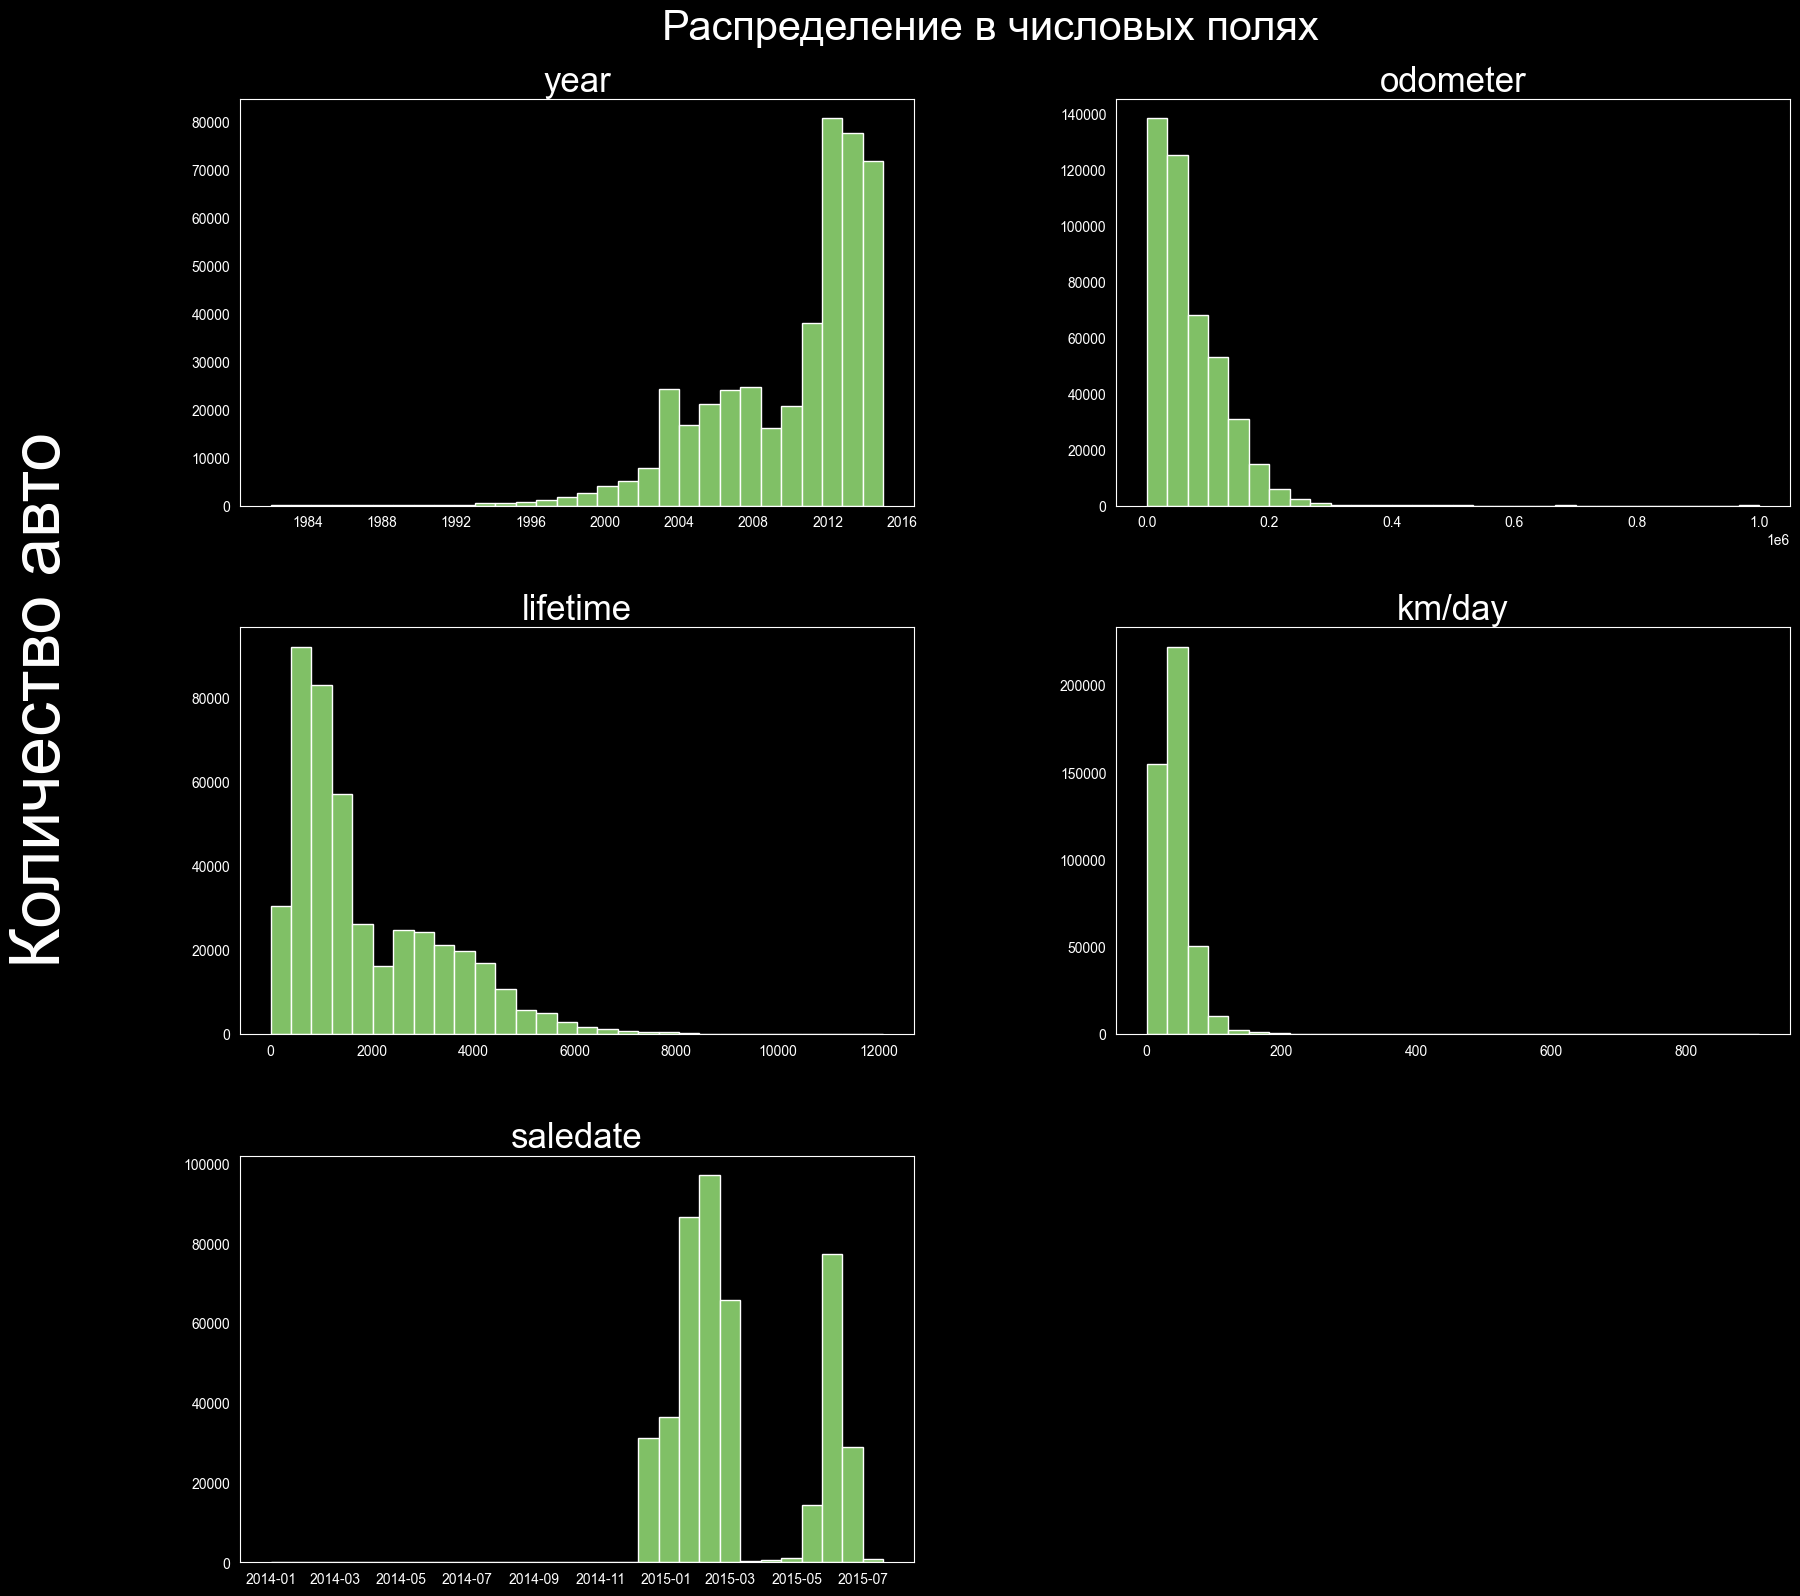

In [17]:
fig = plt.figure()
plot_num = 1
fig.text(0.01, 0.75, 'Количество авто', va='center', rotation='vertical', size=50) 

# цикл по столбцам
for col in num_cols:
    
    ax = fig.add_subplot(len(num_cols), 2, plot_num)
    ax.hist(df[col], bins=30, color=plt.cm.summer(0.5)) 
    ax.set_title(col,size=25)
#   ax.set_ylabel('Количество пользователей',size=18) # если нужно будет добавить подпись оси Y на каждый график
    plot_num += 1

fig.set_size_inches(20, 30)
fig.suptitle('Распределение в числовых полях', fontsize=30)
fig.subplots_adjust(top=0.95,hspace=0.3,wspace=0.3)
plt.show()

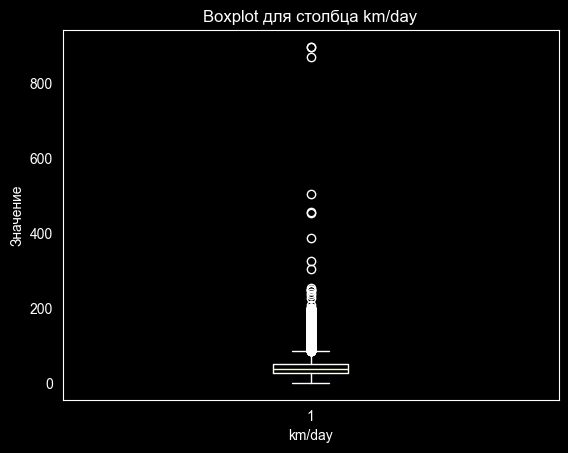

In [18]:
plt.boxplot(test['km/day'])

# Настройка осей и заголовка
plt.xlabel('km/day')
plt.ylabel('Значение')
plt.title('Boxplot для столбца km/day')

# Отображение графика

plt.show()

In [19]:
def groupby_left(df,column,agg):
    """Функция берёт на вход датафрейм, название столбца и название функций.
    По ним будет производиться группировка по столбцу с стоимостью авто."""
    return df.groupby(column)['sellingprice'].agg(agg)

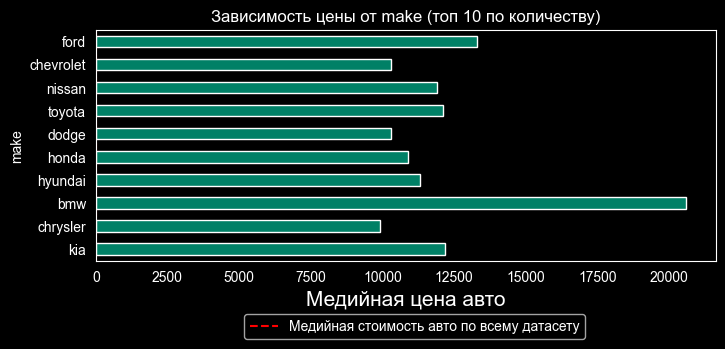

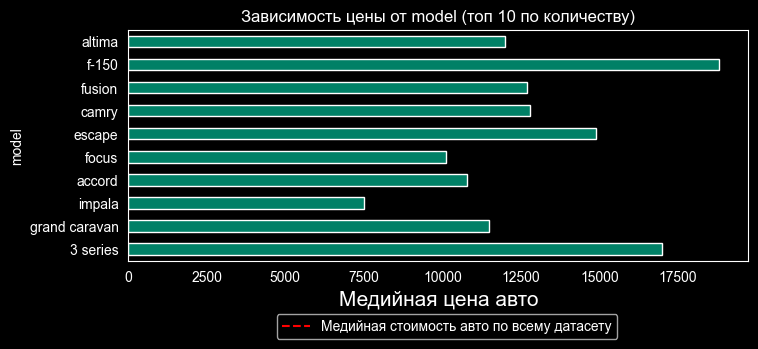

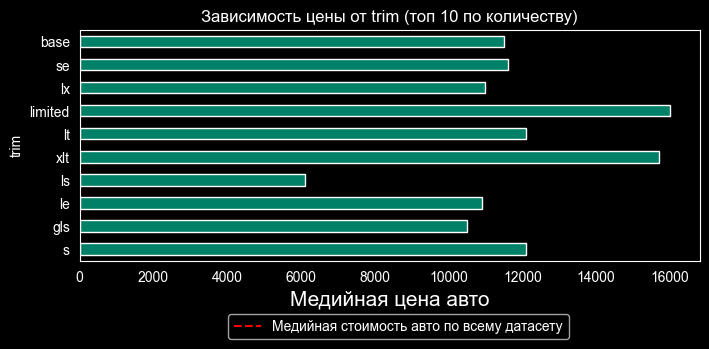

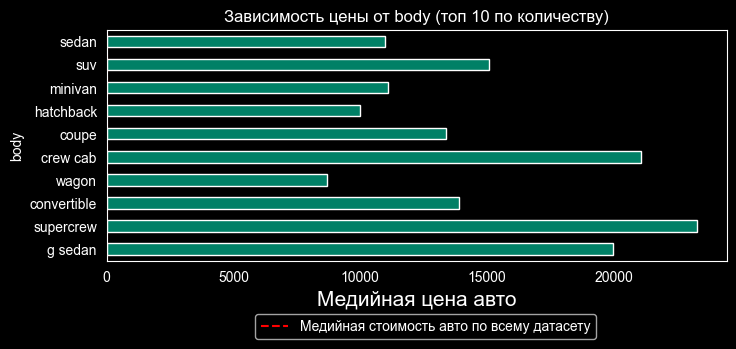

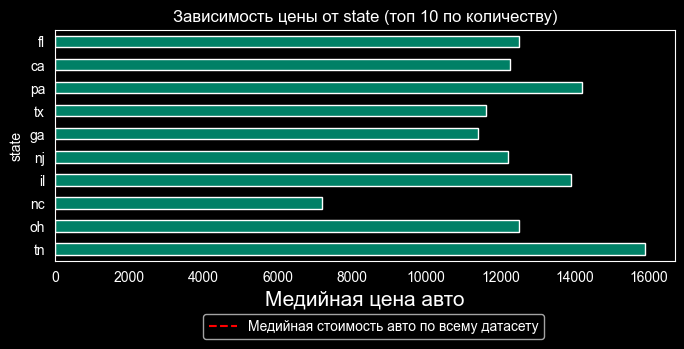

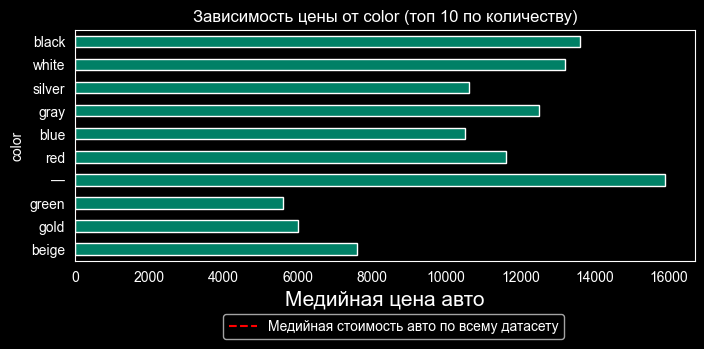

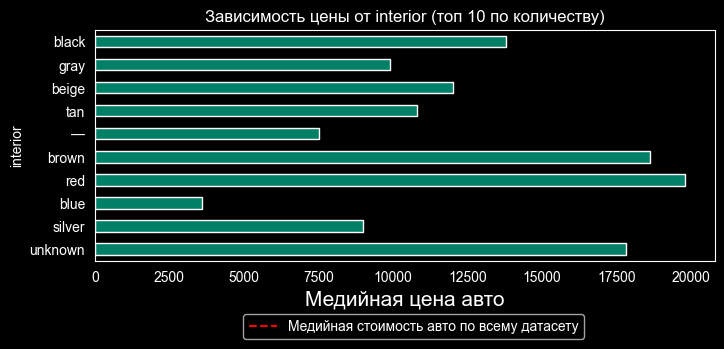

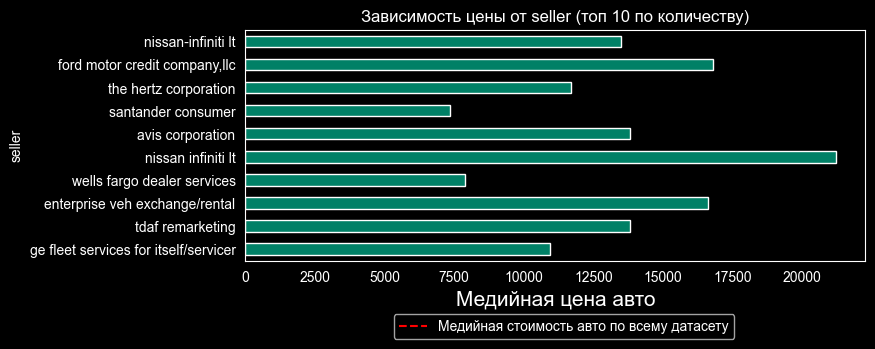

In [20]:
features = cat_cols + num_cols
cmap = plt.cm.summer(0.5)
agg = 'median'

for column in cat_cols:

    top = (groupby_left(df,column,['count',agg])
                       .sort_values(by = 'count', ascending = False)
                       .head(10).sort_values('count')[agg])
    plot = top.plot(kind='barh',cmap=plt.cm.summer, figsize=(8,3),rot=0,grid=True,legend=False)

    if df[column].unique().shape[0] >= 10:
        plt.title(f'Зависимость цены от {column} (топ 10 по количеству)')
    else:
        plt.title(f'Зависимость цены от {column}')

    plt.xlabel('Медийная цена авто',size = 15)
    plt.axvline(x=round(df[target].agg(agg),5),
                color='red', linestyle='--', 
                label='Средняя стоимость авто')
    
    means = round(groupby_left(df,column,[agg]).loc[:, agg],2)
    
    # for i, bar in enumerate(plot.get_children()[:len(means)]):
    #     bar.set_color(cmap(i / len(means)))
    
    # for x, y, label in zip(range(len(means)), means, means):
    #     plt.text(x, y+0.02, label, ha='center', va='bottom')
    plt
    plt.grid(color='black',alpha=0.2)
    plt.legend(['Медийная стоимость авто по всему датасету'],fontsize='medium',bbox_to_anchor=(0.8, -0.2))
    plt.show()

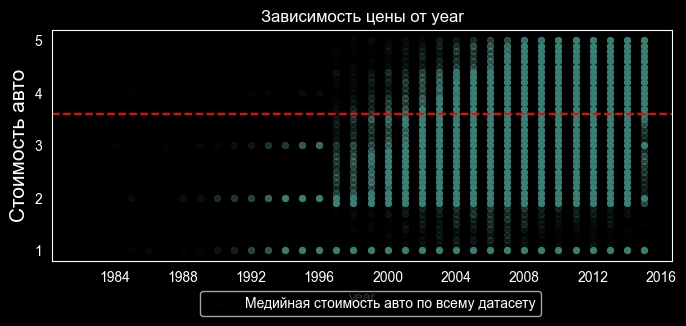

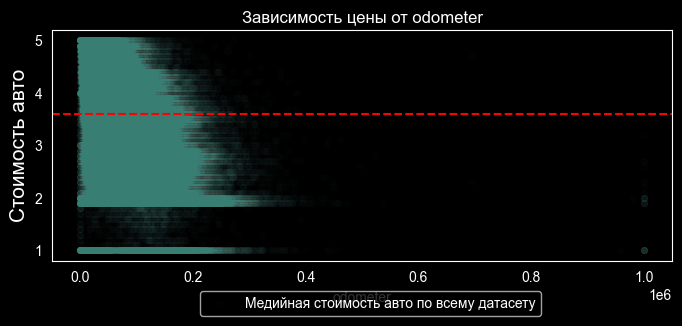

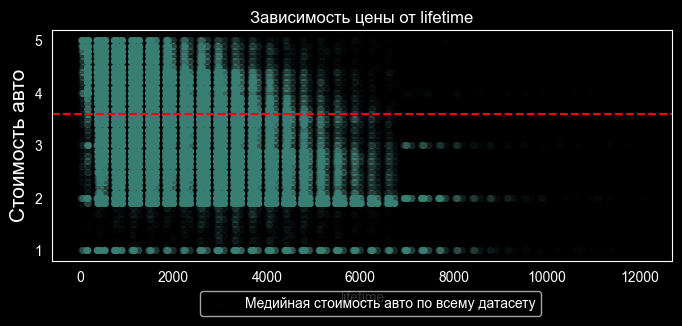

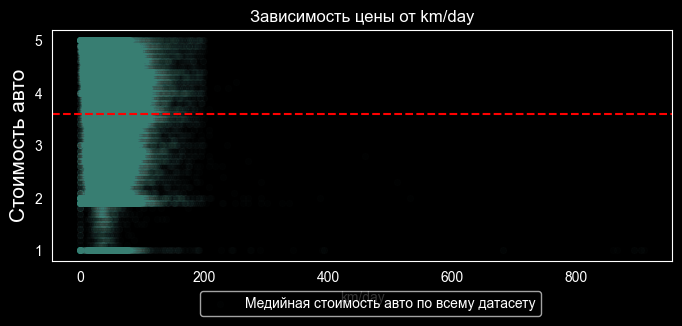

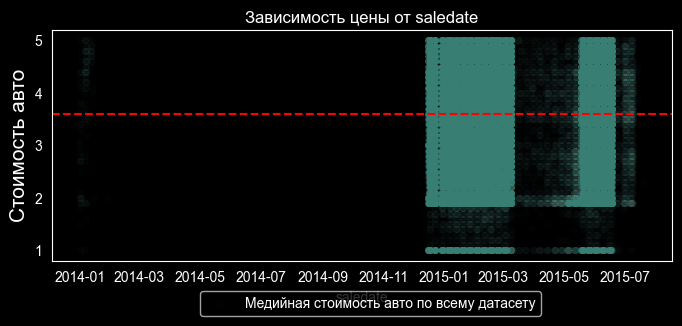

In [21]:
for column in num_cols:

    plot = df.plot(x=column,y=target,kind='scatter', 
                    cmap=plt.cm.summer, 
                    figsize=(8,3), rot=0, 
                    grid=True, legend=False, 
                    alpha = 0.01)

    plt.title(f'Зависимость цены от {column}')

    plt.ylabel('Стоимость авто',size = 15) 
    plt.axhline(y=round(df[target].agg(agg),5),
                color='red', linestyle='--', 
                label='Медийная стоимость авто')

    plt
    plt.grid(color='black',alpha=0.2)
    plt.legend(['Медийная стоимость авто по всему датасету'],fontsize='medium',bbox_to_anchor=(0.8, -0.1))
    plt.show()

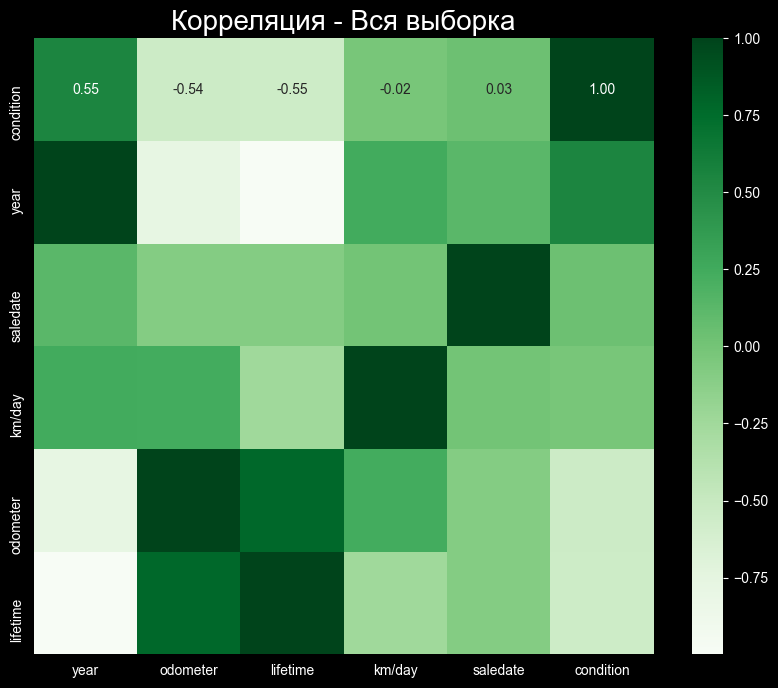

In [22]:
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols+[target]].corr().sort_values(by=target, ascending=False),
            annot=True, 
            cmap="Greens", 
            fmt='.2f')
plt.title('Корреляция - Вся выборка',size=20)
plt.show()

In [23]:
for i in train[cat_cols]:

    value_counts = train[i].value_counts()

    rare_values = value_counts[value_counts < 16].index.tolist()

    train[i] = train[i].apply(lambda x: 'rare' if x in rare_values else x)

for i in test[cat_cols]:

    value_counts = test[i].value_counts()

    rare_values = value_counts[value_counts < 4].index.tolist()

    test[i] = test[i].apply(lambda x: 'rare' if x in rare_values else x)

In [24]:
def to_float(df,_):
    '''Функция преобразует формат столбце в минимально подходящий формат float
    на вход подаётся название датафрейма и столбца.'''
    df[_] = pd.to_numeric(df[_], downcast='float',errors='coerce')
    
def to_uint(df,_):
    '''Функция преобразует формат столбце в минимально подходящий формат uint
    на вход подаётся название датафрейма и столбца.'''
    df[_] = pd.to_numeric(df[_], downcast='unsigned',errors='coerce')

def to_int(df,_):
    '''Функция преобразует формат столбце в минимально подходящий формат int
    на вход подаётся название датафрейма и столбца.'''
    df[_] = pd.to_numeric(df[_], downcast='integer',errors='coerce')

In [25]:
test = test.drop('saledate',axis=1)
train = train.drop('saledate',axis=1)

train['year'] = train['year'].dt.year
test['year'] = test['year'].dt.year

In [26]:
to_uint(train,'sellingprice')
to_uint(train,'lifetime')
to_uint(train,'year')
# to_float(train,'odometer')
# to_float(train,'condition')
to_float(train,'km/day')

to_uint(test,'lifetime')
to_uint(test,'year')
# to_float(test,'odometer')
# to_float(test,'condition')
to_float(test,'km/day')

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  uint16 
 1   make          440236 non-null  object 
 2   model         440236 non-null  object 
 3   trim          440236 non-null  object 
 4   body          440236 non-null  object 
 5   transmission  388763 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440236 non-null  float64
 10  color         440236 non-null  object 
 11  interior      440236 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  uint32 
 14  lifetime      440236 non-null  uint16 
 15  km/day        440236 non-null  float32
dtypes: float32(1), float64(2), object(10), uint16(2), uint32(1)
memory usage: 45.3+ MB


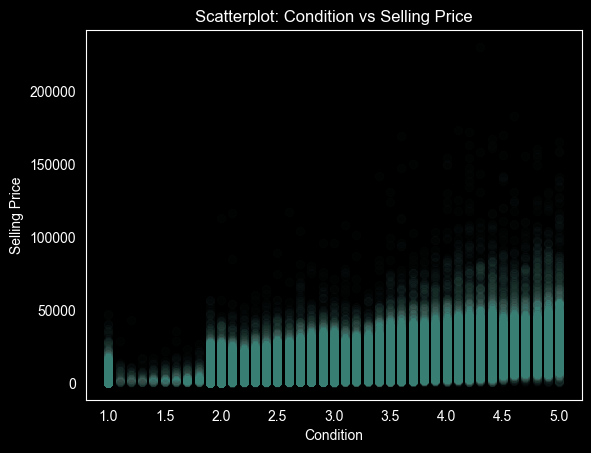

In [28]:
plt.scatter(train['condition'],train['sellingprice'], alpha=0.01)

plt.xlabel('Condition')
plt.ylabel('Selling Price')
plt.title('Scatterplot: Condition vs Selling Price')

plt.show()

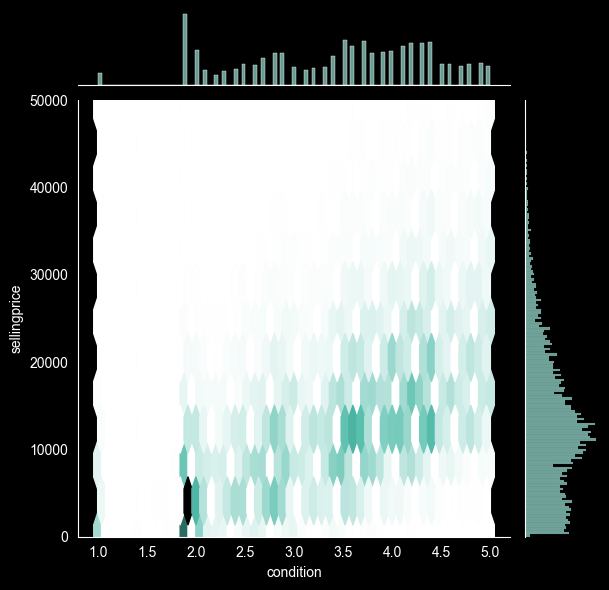

In [29]:
sns.jointplot("condition", "sellingprice", train, kind='hex',gridsize=50)
plt.ylim(0,50000)
plt.show()

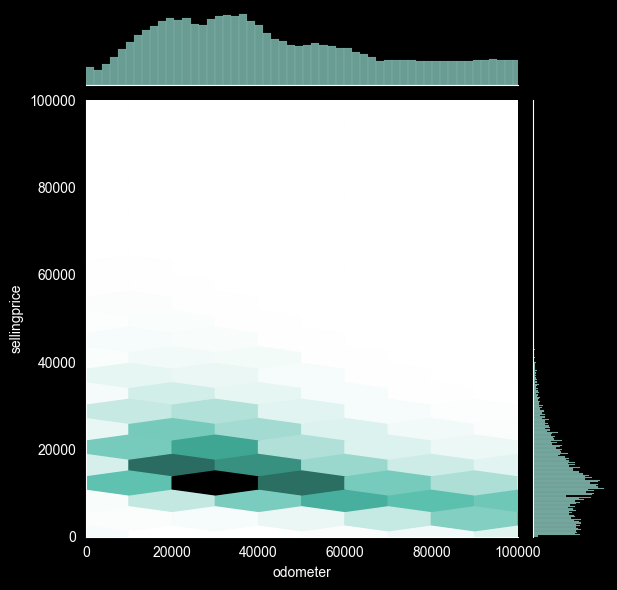

In [30]:
sns.jointplot("odometer", "sellingprice", train, kind='hex')
plt.ylim(0,100000)
plt.xlim(0,100000)
plt.show()

In [31]:
target = 'sellingprice'
plt.figure(figsize=(10,8))
sns.heatmap(train[num_cols+[target]+['age_type']].corr().sort_values(by=target, ascending=False),
            annot=True, 
            cmap="Greens", 
            fmt='.2f')
plt.title('Корреляция - Вся выборка',size=20)
plt.show()

KeyError: "['saledate', 'age_type'] not in index"

<Figure size 1000x800 with 0 Axes>

In [ ]:
# df = train.copy().drop(['vin'], axis=1)
valid_condition = train[train['condition'].isna()==False].copy().drop('transmission',axis=1)
pred_condition = train[train['condition'].isna()==True].copy().drop('transmission',axis=1)

X = valid_condition.drop([target]+['vin'], axis=1)
y = valid_condition[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = s)

num_cols = ['year', 'odometer', 'lifetime', 'km/day', 'sellingprice']
metric = 'MAPE'
activate_coders()

print('Размер признаков в обучабщей выборке:',X_train.shape[0])
print('Размер признаков в тестовой выборке:',X_test.shape[0])
print('Размер таргета в обучабщей выборке:',y_train.shape[0])
print('Размер таргета в тестовой выборке:',y_test.shape[0])

Размер признаков в обучабщей выборке: 352188
Размер признаков в тестовой выборке: 88048
Размер таргета в обучабщей выборке: 352188
Размер таргета в тестовой выборке: 88048


## Кодеры

In [3]:
try:
    train = pd.read_csv('preprocessed_train').drop('Unnamed: 0',axis=1)
    test = pd.read_csv('preprocessed_test').drop('Unnamed: 0',axis=1)
    print('Выгружены предобработанные датасеты')

except:
    print('Используются имеющиеся датасеты train и test')

In [2]:
def fill_avg_column(groupby_data,apply_data, group_columns, value_column, agg_func):
    grouped_data = groupby_data.groupby(group_columns)[value_column].agg(agg_func)
    
    def fill_avg(row):
        group_values = tuple(row[column] for column in group_columns)
        
        if group_values in grouped_data.index:
            avg_value = grouped_data.loc[group_values]
        else:
            avg_value = grouped_data.mean()
        
        return avg_value
    
    return apply_data.apply(fill_avg, axis=1)

In [4]:
train['avg_sellingprice'] = fill_avg_column(train,train, ['year', 'make', 'model'], 'sellingprice', 'mean')
train['avg_condition'] = fill_avg_column(train,train, ['year', 'make', 'model'], 'condition', 'mean')
test['avg_sellingprice'] = fill_avg_column(train,test, ['year', 'make', 'model'], 'sellingprice', 'mean')
test['avg_condition'] = fill_avg_column(test,test, ['year', 'make', 'model'], 'condition', 'mean')

In [32]:
def get_country_region(vin):
    car = Vin(vin)
    return car.country, car.region

train['country'], train['region'] = zip(*train['vin'].map(get_country_region))
test['country'], test['region'] = zip(*test['vin'].map(get_country_region))

In [39]:
metric = 'MAPE'
target = 'condition'
cat_cols = ['make', 'model', 'trim', 'body','state','color','interior','seller']
num_cols = list(test.columns.drop(cat_cols+['vin']+[target]))

def activate_coders():

    ohe = ColumnTransformer([('encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                                ('scaler', MinMaxScaler(), num_cols)],
                                    remainder='passthrough')

    oe = ColumnTransformer([('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
                                ('scaler', MinMaxScaler(), num_cols)],
                                remainder='passthrough')
    return ohe, oe 

pd.options.display.float_format = '{: .3f}'.format
ohe,oe = activate_coders()

results = pd.DataFrame(columns=[metric,'Время обучения','Время предсказания'])
results

,MAPE,Время обучения,Время предсказания


In [34]:
def metrics(df,model,score,fit,pred):
    f'''Функция берёт на вход датафрейм, название модели, показаетль {metric} (по CV),
    время обучения и время предсказания. Добавляет строку с показателями модели.'''
    
    df.loc[model,'Время обучения'] = fit
    df.loc[model,'Время предсказания'] = pred
    df.loc[model, metric] = score
    
    return df

In [35]:
def grid_fit(model,params,X_train, y_train, cv=4):
    f"""Фукция берет на вход модель, и гиперпараметры для GridSearchCV.
    Проводит обучение с выявлением лучших гиперпараметров по метрике {metric}.
    Возвращает обученную модель, лучший {metric}, время обучения и предсказания модели."""
    
    grid = GridSearchCV(model, 
                        param_grid=params, 
                        scoring='neg_mean_absolute_percentage_error',
                        cv = cv)
        
    grid.fit(X_train,y_train)
    
    i = (list(grid.cv_results_['rank_test_score'])).index(1)
    score = grid.cv_results_['mean_test_score'][i]*-1
    time_fit = grid.cv_results_['mean_fit_time'][i]
    time_pred = grid.cv_results_['mean_score_time'][i]
    
    print('Лучшие параметры модели:', grid.best_params_)
    print(metric, score)
    print('Время обучения модели:', time_fit)
    print('Время предсказания модели:', time_pred)
    
    return grid, score, time_fit, time_pred

def random_fit(model, params, X_train, y_train, cv=4):
    """Функция берет на вход модель и гиперпараметры для RandomizedSearchCV.
    Проводит обучение с выявлением лучших гиперпараметров по метрике {metric}.
    Возвращает обученную модель, лучший {metric}, время обучения и предсказания модели."""

    random_search = RandomizedSearchCV(model,
                                       param_distributions=params,
                                       scoring='neg_mean_absolute_percentage_error',
                                       cv=cv)

    random_search.fit(X_train, y_train)

    i = (list(random_search.cv_results_['rank_test_score'])).index(1)
    score = random_search.cv_results_['mean_test_score'][i] * -1
    time_fit = random_search.cv_results_['mean_fit_time'][i]
    time_pred = random_search.cv_results_['mean_score_time'][i]

    print('Лучшие параметры модели:', random_search.best_params_)
    print(metric, score)
    print('Время обучения модели:', time_fit)
    print('Время предсказания модели:', time_pred)

    return random_search, score, time_fit, time_pred
    

def optuna_fit(model, params, X_train, y_train, cv=4, n_trials=10, 
                timeout = 7200, scoring='neg_mean_absolute_percentage_error', scoring_type='neg',
                direction='minimize'):

    """Функция берет на вход модель и гиперпараметры для байесовской оптимизации.
    Проводит ... обучение с выявлением лучших гиперпараметров по метрике {metric}.
    Возвращает обученную модель, лучший {metric}, время обучения и предсказания модели."""

    def objective(trial):
        # Определение пространства гиперпараметров
        param_values = {}
        for param_name, param_range in params.items():
            if isinstance(param_range, list):
                param_values[param_name] = trial.suggest_categorical(param_name, param_range)
            elif isinstance(param_range, tuple):
                if param_range[2] == int:
                    param_values[param_name] = trial.suggest_int(param_name, param_range[0], param_range[1])
                elif param_range[2] == float:
                    param_values[param_name] = trial.suggest_float(param_name, param_range[0], param_range[1])
                elif param_range[2] == 'discrete_uniform':
                    param_values[param_name] = trial.suggest_discrete_uniform(param_name, param_range[0], param_range[1], param_range[3])
            else:
                param_values[param_name] = param_range

        # Установка гиперпараметров модели
        model.set_params(**param_values)

        # Выполнение кросс-валидации
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)

        if scoring_type == 'neg':
            scores *=-1

        return scores.mean()

    sampler = TPESampler(seed=s)
    study = optuna.create_study(direction=direction, pruner='Hyperband',sampler=sampler)
    study.optimize(objective, n_trials=n_trials,timeout=timeout)

    best_params = study.best_params
    best_score = study.best_value
    time_fit = study.best_trial.duration.total_seconds()/cv
    time_pred = None  # В оптимизации с помощью Optuna нет времени предсказания

    print('Лучшие параметры модели:', best_params)
    print(metric, best_score)
    print('Время обучения модели:', time_fit)
    print('Время предсказания модели:', time_pred)

    return study, best_score, time_fit, time_pred


In [50]:
def pred(model):
    f"""Функция берёт на вход модель, обучает её на обучающей выборке,
    делает предсказания и проверяет {metric} на тестовой выборке.
    На выход идёт MAPE, время обучения и предсказания."""
    
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    time_fit = end - start

    start = time.time()
    preds = model.predict(X_test)
    end = time.time()
    score = mean_absolute_percentage_error(y_test, preds)
    time_pred = end - start
    
    print('Время обучения модели:', time_fit)
    print('Время предсказания модели:', time_pred)
    print(f'{metric}', score)
    
    return model, preds, score, time_fit, time_pred

# Восполнение пропусков с помощью машинного обучения

## Предсказание Condition

In [46]:
valid_condition = train[train['condition'].isna()==False].copy().drop('transmission',axis=1)
pred_condition = train[train['condition'].isna()==True].copy().drop('transmission',axis=1)

X = valid_condition.drop([target]+['vin'], axis=1)
y = valid_condition[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = s)

cat_cols = ['make', 'model', 'trim', 'body', 'state', 'color', 'interior', 'seller','country','region']
num_cols = ['year', 'odometer', 'lifetime', 'km/day', 'sellingprice']
features = num_cols+cat_cols
metric = 'MAPE'
ohe, oe = activate_coders()

print('Размер признаков в обучабщей выборке:',X_train.shape[0])
print('Размер признаков в тестовой выборке:',X_test.shape[0])
print('Размер таргета в обучабщей выборке:',y_train.shape[0])
print('Размер таргета в тестовой выборке:',y_test.shape[0])

Размер признаков в обучабщей выборке: 344664
Размер признаков в тестовой выборке: 86167
Размер таргета в обучабщей выборке: 344664
Размер таргета в тестовой выборке: 86167


In [45]:
valid_condition.info(
)

<class 'pandas.core.frame.DataFrame'>
Index: 430831 entries, 0 to 440235
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          430831 non-null  uint16 
 1   make          430831 non-null  object 
 2   model         430831 non-null  object 
 3   trim          430831 non-null  object 
 4   body          430831 non-null  object 
 5   vin           430831 non-null  object 
 6   state         430831 non-null  object 
 7   condition     430831 non-null  float64
 8   odometer      430831 non-null  float64
 9   color         430831 non-null  object 
 10  interior      430831 non-null  object 
 11  seller        430831 non-null  object 
 12  sellingprice  430831 non-null  uint32 
 13  lifetime      430831 non-null  uint16 
 14  km/day        430831 non-null  float32
 15  country       430831 non-null  object 
 16  region        430831 non-null  object 
dtypes: float32(1), float64(2), object(11), uint16(2), uin

In [47]:
%%time

model = LinearRegression()

pipe = Pipeline([('ohe', ohe),
                 ('lr', model)])

params = {
        'lr__fit_intercept': [False,True],
        'lr__copy_X': [True,False]
          }

study, score, time_fit, time_pred = optuna_fit(pipe, params,X_train, y_train, cv=4, n_trials=4)

metrics(results, 'LinearRegression_optuna_ohe', score, time_fit, time_pred)

[I 2023-09-26 18:02:43,236] A new study created in memory with name: no-name-0e3665be-9ad9-40eb-9c24-dea5fe5fb1e8
[I 2023-09-26 18:03:53,060] Trial 0 finished with value: 0.1805814087894329 and parameters: {'lr__fit_intercept': True, 'lr__copy_X': True}. Best is trial 0 with value: 0.1805814087894329.
[I 2023-09-26 18:04:56,629] Trial 1 finished with value: 0.18058234733157497 and parameters: {'lr__fit_intercept': False, 'lr__copy_X': False}. Best is trial 0 with value: 0.1805814087894329.
[I 2023-09-26 18:05:58,087] Trial 2 finished with value: 0.1805814087894329 and parameters: {'lr__fit_intercept': True, 'lr__copy_X': False}. Best is trial 0 with value: 0.1805814087894329.
[I 2023-09-26 18:07:02,237] Trial 3 finished with value: 0.18058234733157497 and parameters: {'lr__fit_intercept': False, 'lr__copy_X': False}. Best is trial 0 with value: 0.1805814087894329.


Лучшие параметры модели: {'lr__fit_intercept': True, 'lr__copy_X': True}
MAPE 0.1805814087894329
Время обучения модели: 17.45552175
Время предсказания модели: None
CPU times: total: 3min 42s
Wall time: 4min 19s


,MAPE,Время обучения,Время предсказания
LinearRegression_optuna_ohe,0.181,17.456,None


In [48]:
model = CatBoostRegressor(loss_function='MAE',
                          random_state=s,
                          early_stopping_rounds=100,
                          verbose=False,
                          eval_metric = metric
                          )

pipe = Pipeline([('ohe', ohe),
                 ('cbr', model)])

# Определение пространства гиперпараметров
params = {
        'cbr__learning_rate': (0.4, 0.7, float),
        'cbr__depth': 8
          }

# Обучение модели с помощью оптимизации с помощью Optuna
study, score, time_fit, time_pred = optuna_fit(pipe, params, X_train, y_train, cv=4, n_trials=5)

metrics(results, 'CatBoostRegressor_optuna_ohe', score, time_fit, time_pred)

[I 2023-09-26 18:07:02,267] A new study created in memory with name: no-name-1b45de38-02b5-4c7f-976c-29f5739e7667
[I 2023-09-26 18:12:51,555] Trial 0 finished with value: 0.15993197151697078 and parameters: {'cbr__learning_rate': 0.5123620356542088}. Best is trial 0 with value: 0.15993197151697078.
[I 2023-09-26 18:18:26,126] Trial 1 finished with value: 0.16076784907874997 and parameters: {'cbr__learning_rate': 0.6852142919229748}. Best is trial 0 with value: 0.15993197151697078.
[I 2023-09-26 18:23:51,981] Trial 2 finished with value: 0.16019494717850927 and parameters: {'cbr__learning_rate': 0.6195981825434215}. Best is trial 0 with value: 0.15993197151697078.
[I 2023-09-26 18:29:02,995] Trial 3 finished with value: 0.16011128443923167 and parameters: {'cbr__learning_rate': 0.579597545259111}. Best is trial 0 with value: 0.15993197151697078.
[I 2023-09-26 18:34:12,125] Trial 4 finished with value: 0.15974049819545072 and parameters: {'cbr__learning_rate': 0.44680559213273097}. Best 

Лучшие параметры модели: {'cbr__learning_rate': 0.44680559213273097}
MAPE 0.15974049819545072
Время обучения модели: 77.28253975
Время предсказания модели: None


,MAPE,Время обучения,Время предсказания
LinearRegression_optuna_ohe,0.181,17.456,None
CatBoostRegressor_optuna_ohe,0.160,77.283,None


Лучшие параметры модели: {'cbr__learning_rate': 0.44680559213273097}
MAPE 0.15974049819545072

In [51]:
model = CatBoostRegressor(loss_function='RMSE',
                          random_state=s,
                          early_stopping_rounds=100,
                          verbose=1000,
                          learning_rate=0.44680559213273097,
                          depth=8)

pipe = Pipeline([('ohe', ohe),
                 ('cbr', model)])

# Обучение модели с помощью оптимизации с помощью Optuna
model, preds, score, time_fit, time_pred = pred(pipe)

final = pd.DataFrame(columns=['Время обучения','Время предсказания','MAPE'])
metrics(final, 'CatBoostRegressor_optuna_ohe', score, time_fit, time_pred)

0:	learn: 0.7880945	total: 102ms	remaining: 1m 41s
999:	learn: 0.5429124	total: 1m 24s	remaining: 0us
Время обучения модели: 89.79715657234192
Время предсказания модели: 1.784623622894287
MAPE 0.15781254055789234


,Время обучения,Время предсказания,MAPE
CatBoostRegressor_optuna_ohe,89.797,1.785,0.158


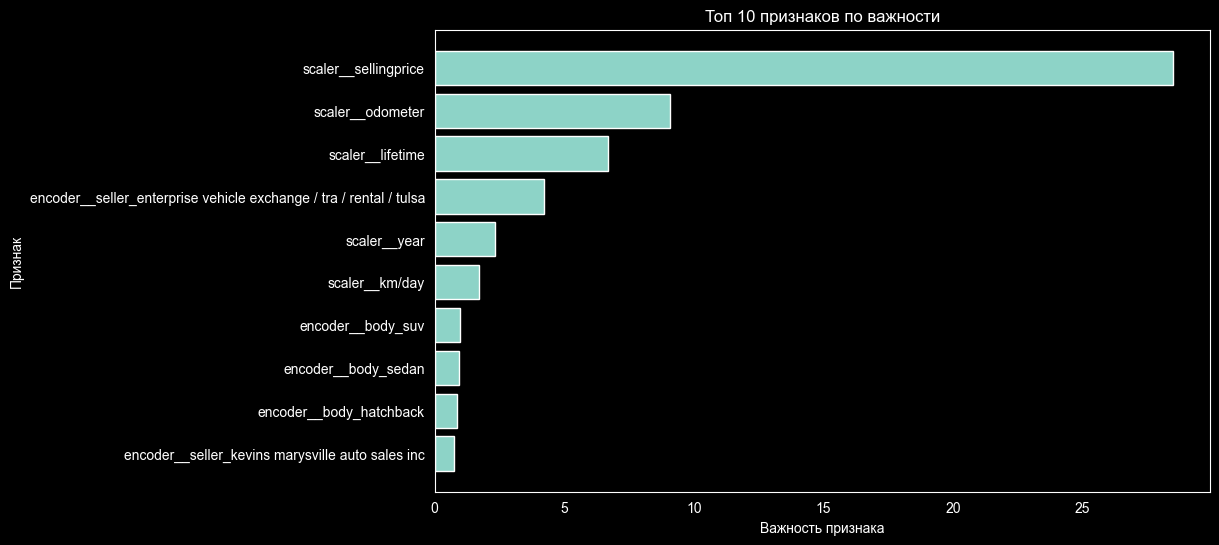

In [52]:

feature_importance = model.named_steps['cbr'].feature_importances_
feature_names = model.named_steps['ohe'].get_feature_names_out()
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Вывод важности признаков
top_n = 10  # Количество признаков для отображения
top_feature_names = sorted_feature_names[:top_n]
top_feature_importance = sorted_feature_importance[:top_n]
top_imp =pd.Series(top_feature_importance, index=top_feature_names).sort_values()

# Создание графика
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_imp, align='center')
plt.yticks(range(top_n), top_imp.index)
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Топ 10 признаков по важности')
plt.show()

In [53]:
pipe.fit(valid_condition[features], valid_condition[target])
preds = pipe.predict(pred_condition[features])
predicted_data_train = pred_condition.copy()
predicted_data_train['condition'] = preds
predicted_data_train

0:	learn: 0.7907091	total: 111ms	remaining: 1m 51s
999:	learn: 0.5484886	total: 1m 34s	remaining: 0us


,year,make,model,trim,body,vin,state,condition,odometer,color,interior,seller,sellingprice,lifetime,km/day,country,region
89,1999,mercedes-benz,e-class,unknown,sedan/saloon,wdbjf25h9xa799907,mi,2.090,219516.000,green,beige,rare,400,5830,37.653,Germany,Europe
122,2007,suzuki,reno,base,hatchback,kl5jd66z97k726834,il,2.072,127936.000,red,—,ray chevrolet inc,1800,2908,43.994,South Korea,Asia
298,2006,chevrolet,silverado 1500,lt3,crew cab,2gcek13t761205016,ne,2.389,231208.000,burgundy,gray,woodhouse ford inc,6000,3273,70.641,Canada,North America
303,2013,kia,sorento,lx,suv,5xyktda60dg359259,il,3.921,31404.000,burgundy,—,rare,16500,716,43.860,United States,North America
326,2005,jeep,liberty,sport,suv,1j8gl48k25w621160,pa,3.733,102341.000,black,—,adcock brothers inc,4200,3639,28.123,United States,North America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439900,2001,infiniti,i30,base,sedan,jnkca31a81t019350,az,1.956,194302.000,brown,brown,right honda,1300,5099,38.106,Japan,Asia
439920,2013,chevrolet,silverado 1500,lt,extended cab,1gcrcse01dz410293,az,3.657,19431.000,black,black,yates buick gmc inc,22800,716,27.138,United States,North America
440145,2010,mazda,mazda3,s grand touring,hatchback,jm1bl1h63a1137542,nj,2.943,104692.000,gray,—,rare,6650,1811,57.809,Japan,Asia
440166,2005,nissan,maxima,3.5 sl,sedan,1n4ba41e45c809875,fl,2.239,152938.000,gray,gray,gettel nissan of sarasota,2800,3638,42.039,United States,North America


In [55]:
data = predicted_data_train
for i in data.index: 
    train.loc[i,'condition'] = data.loc[i,'condition']

In [58]:
valid_condition = train.copy().drop(['transmission','sellingprice'],axis=1)
pred_condition_test = test[test['condition'].isna()==True].copy().drop('transmission',axis=1)

X = valid_condition.drop([target]+['vin'], axis=1)
y = valid_condition[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = s)

features.remove('sellingprice')
num_cols.remove('sellingprice')

ohe, oe = activate_coders()

In [217]:
# valid_condition_test = test[test['condition'].isna()==False].copy().drop('transmission',axis=1)
# pred_condition_test = test[test['condition'].isna()==True].copy().drop('transmission',axis=1)

# full_valid = pd.concat([valid_condition,valid_condition_test]).drop('sellingprice',axis=1)
# full_pred = pd.concat([pred_condition,pred_condition_test]).drop('sellingprice',axis=1)

# X = full_valid.drop([target]+['vin'], axis=1)
# y = full_valid[target]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = s)

# features.remove('sellingprice')
# num_cols.remove('sellingprice')

# ohe,oe = activate_coders(cat_cols=cat_cols, num_cols=num_cols)

In [72]:
model = CatBoostRegressor()

pipe = Pipeline([('ohe', ohe),
                 ('cbr', model)])

# Определение пространства гиперпараметров
params = {
        'cbr__learning_rate': (0.4, 0.6, float),
        'cbr__depth': 7,
        'cbr__loss_function':'RMSE',
        'cbr__random_state': s,
        'cbr__early_stopping_rounds' : 20,
        'cbr__eval_metric' : metric,
        'cbr__verbose':False
          }

# Обучение модели с помощью оптимизации с помощью Optuna
study, score, time_fit, time_pred = optuna_fit(pipe,params,cv=4,X_train=X_train,y_train=y_train,n_trials=5,timeout = 3600)

metrics(results, 'CatBoostRegressor_optuna_ohe', score, time_fit, time_pred)

[I 2023-09-26 21:27:37,613] A new study created in memory with name: no-name-2780f1b4-38fb-4289-9e3d-64c1968d6999


[I 2023-09-26 21:31:51,960] Trial 0 finished with value: 0.1774825393747456 and parameters: {'cbr__learning_rate': 0.4749080237694725}. Best is trial 0 with value: 0.1774825393747456.
[I 2023-09-26 21:35:52,747] Trial 1 finished with value: 0.1780365275937562 and parameters: {'cbr__learning_rate': 0.5901428612819832}. Best is trial 0 with value: 0.1774825393747456.
[I 2023-09-26 21:39:51,641] Trial 2 finished with value: 0.1777028069128612 and parameters: {'cbr__learning_rate': 0.546398788362281}. Best is trial 0 with value: 0.1774825393747456.
[I 2023-09-26 21:43:49,126] Trial 3 finished with value: 0.1778029413638653 and parameters: {'cbr__learning_rate': 0.5197316968394073}. Best is trial 0 with value: 0.1774825393747456.
[I 2023-09-26 21:47:46,085] Trial 4 finished with value: 0.1775694043330908 and parameters: {'cbr__learning_rate': 0.43120372808848734}. Best is trial 0 with value: 0.1774825393747456.


Лучшие параметры модели: {'cbr__learning_rate': 0.4749080237694725}
MAPE 0.1774825393747456
Время обучения модели: 63.58643375
Время предсказания модели: None


,MAPE,Время обучения,Время предсказания
LinearRegression_optuna_ohe,0.181,17.456,None
CatBoostRegressor_optuna_ohe,0.177,63.586,None


In [73]:
model = CatBoostRegressor(loss_function='RMSE',
                          random_state=s,
                          early_stopping_rounds=20,
                          verbose=1000,
                          learning_rate=0.4749080237694725,
                          depth=7)



pipe = Pipeline([('ohe', ohe),
                 ('cbr', model)])

pipe.fit(valid_condition[features], valid_condition[target])

preds = pipe.predict(pred_condition_test[features])
predicted_data_test = pred_condition_test.copy()
predicted_data_test['condition'] = preds

0:	learn: 0.8072329	total: 91.5ms	remaining: 1m 31s
999:	learn: 0.6156824	total: 1m 17s	remaining: 0us


In [74]:
data = predicted_data_test
for i in data.index: 
    test.loc[i,'condition'] = data.loc[i,'condition']

## Предсказание transmission

In [75]:
train['transmission'] = train['transmission'].replace('automatic',1).replace('manual',0).astype('Int8')
test['transmission'] = test['transmission'].replace('automatic',1).replace('manual',0).astype('Int8')

In [80]:
num_cols = ['year', 'odometer', 'lifetime', 'km/day', 'condition','sellingprice']
cat_cols = ['make', 'model', 'trim', 'body', 'state', 'color', 'interior', 'seller','region','country']
features = num_cols + cat_cols
target = 'transmission'
metric = 'F1'

valid_transmission = train[train['transmission'].isna()==False].copy()
pred_transmission = train[train['transmission'].isna()==True].copy()

valid_transmission[cat_cols] = valid_transmission[cat_cols].astype('category')
pred_transmission[cat_cols] = pred_transmission[cat_cols].astype('category')

X = valid_transmission.drop([target]+['vin'], axis=1)
y = valid_transmission[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = s)

ohe,oe = activate_coders()

print('Размер признаков в обучабщей выборке:',X_train.shape[0])
print('Размер признаков в тестовой выборке:',X_test.shape[0])
print('Размер таргета в обучабщей выборке:',y_train.shape[0])
print('Размер таргета в тестовой выборке:',y_test.shape[0])

Размер признаков в обучабщей выборке: 311010
Размер признаков в тестовой выборке: 77753
Размер таргета в обучабщей выборке: 311010
Размер таргета в тестовой выборке: 77753


In [81]:
model = CatBoostClassifier()

pipe = Pipeline([('ohe', ohe),
                 ('cbr', model)])

# Определение пространства гиперпараметров
params = {
        'cbr__learning_rate': (0.5, 0.9, float),
        'cbr__depth': 10,
        'cbr__loss_function':'Logloss',
        'cbr__random_state': s,
        'cbr__early_stopping_rounds' : 20,
        'cbr__verbose' : 1000,
        'cbr__eval_metric' : metric,
        'cbr__auto_class_weights' : 'Balanced'
          }

# Обучение модели с помощью оптимизации с помощью Optuna
study, score, time_fit, time_pred = optuna_fit(pipe, params, cv=4, X_train=X_train,
                                                y_train=y_train, n_trials=5, timeout = 3600,
                                                scoring='f1', scoring_type='pos', direction='maximize'
                                                )

best_params = study.best_params

metrics(results, 'CatBoostClassifier_transmission_ohe', score, time_fit, time_pred)

[I 2023-09-26 22:05:52,856] A new study created in memory with name: no-name-4e47832f-5c7b-41db-a20f-34181729d5d6


0:	learn: 0.7610105	total: 381ms	remaining: 6m 20s
999:	learn: 0.9953702	total: 3m 49s	remaining: 0us
0:	learn: 0.7414821	total: 246ms	remaining: 4m 5s
999:	learn: 0.9956303	total: 3m 48s	remaining: 0us
0:	learn: 0.7296789	total: 283ms	remaining: 4m 42s
999:	learn: 0.9957155	total: 3m 49s	remaining: 0us
0:	learn: 0.7579755	total: 242ms	remaining: 4m 1s
999:	learn: 0.9951369	total: 3m 35s	remaining: 0us


[I 2023-09-26 22:21:18,684] Trial 0 finished with value: 0.9725187132264084 and parameters: {'cbr__learning_rate': 0.649816047538945}. Best is trial 0 with value: 0.9725187132264084.


0:	learn: 0.7610105	total: 214ms	remaining: 3m 33s
999:	learn: 0.9974515	total: 3m 24s	remaining: 0us
0:	learn: 0.7414821	total: 202ms	remaining: 3m 21s
999:	learn: 0.9975185	total: 3m 39s	remaining: 0us
0:	learn: 0.7296789	total: 359ms	remaining: 5m 58s
999:	learn: 0.9974203	total: 4m 3s	remaining: 0us
0:	learn: 0.7579755	total: 247ms	remaining: 4m 6s
999:	learn: 0.9975029	total: 4m 4s	remaining: 0us


[I 2023-09-26 22:36:50,761] Trial 1 finished with value: 0.9734013141941166 and parameters: {'cbr__learning_rate': 0.8802857225639664}. Best is trial 1 with value: 0.9734013141941166.


0:	learn: 0.7610105	total: 254ms	remaining: 4m 13s
999:	learn: 0.9968772	total: 4m 2s	remaining: 0us
0:	learn: 0.7414821	total: 262ms	remaining: 4m 22s
999:	learn: 0.9967475	total: 4m 2s	remaining: 0us
0:	learn: 0.7296789	total: 235ms	remaining: 3m 54s
999:	learn: 0.9970158	total: 3m 59s	remaining: 0us
0:	learn: 0.7579755	total: 242ms	remaining: 4m 1s
999:	learn: 0.9969913	total: 3m 55s	remaining: 0us


[I 2023-09-26 22:53:10,783] Trial 2 finished with value: 0.9731710965532367 and parameters: {'cbr__learning_rate': 0.7927975767245621}. Best is trial 1 with value: 0.9734013141941166.


0:	learn: 0.7610105	total: 221ms	remaining: 3m 40s
999:	learn: 0.9964836	total: 3m 41s	remaining: 0us
0:	learn: 0.7414821	total: 221ms	remaining: 3m 40s
999:	learn: 0.9963918	total: 3m 59s	remaining: 0us
0:	learn: 0.7296789	total: 251ms	remaining: 4m 11s
999:	learn: 0.9961948	total: 3m 56s	remaining: 0us
0:	learn: 0.7579755	total: 250ms	remaining: 4m 9s
999:	learn: 0.9962754	total: 3m 56s	remaining: 0us


[I 2023-09-26 23:09:04,416] Trial 3 finished with value: 0.9728687635284532 and parameters: {'cbr__learning_rate': 0.7394633936788146}. Best is trial 1 with value: 0.9734013141941166.


Лучшие параметры модели: {'cbr__learning_rate': 0.8802857225639664}
F1 0.9734013141941166
Время обучения модели: 233.019186
Время предсказания модели: None


,MAPE,Время обучения,Время предсказания,F1
LinearRegression_optuna_ohe,0.181,17.456,None,NaN
CatBoostRegressor_optuna_ohe,0.177,63.586,None,NaN
CatBoostClassifier_transmission_ohe,NaN,233.019,None,0.973


In [82]:
params = {
    'learning_rate': 0.8802857225639664,
    'depth': 10,
    'loss_function': 'Logloss',
    'random_state': s,
    'early_stopping_rounds': 20,
    'verbose': 1000,
    'eval_metric': metric,
    'auto_class_weights': 'Balanced'
}

model = CatBoostClassifier(**params)

pipe = Pipeline([('oe', oe),
                 ('cbr', model)])
                 
model, preds, score, time_fit, time_pred = pred(pipe)

final = pd.DataFrame(columns=['Время обучения','Время предсказания',metric])
metrics(final, 'CatBoostClassifier_transmission_ohe', score, time_fit, time_pred)

0:	learn: 0.7668597	total: 214ms	remaining: 3m 34s
999:	learn: 0.9997516	total: 2m 54s	remaining: 0us
Время обучения модели: 177.63448882102966
Время предсказания модели: 1.3452093601226807
F1 98293423631856.42


,Время обучения,Время предсказания,F1
CatBoostClassifier_transmission_ohe,177.634,1.345,98293423631856.422


In [83]:
pipe.fit(valid_transmission[features], valid_transmission[target])
preds = pipe.predict(pred_transmission[features])
predicted_data_train = pred_transmission.copy()
predicted_data_train['transmission'] = preds
predicted_data_train.sample(3)

0:	learn: 0.7657714	total: 222ms	remaining: 3m 41s
999:	learn: 0.9996159	total: 3m 24s	remaining: 0us


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,lifetime,km/day,country,region
293255,2014,jeep,cherokee,sport,suv,1,1c4pjlab1ew112419,pa,4.000,12648.000,black,black,pv holding inc/gdp,18000,385,32.852,United States,North America
14886,2012,mitsubishi,galant,unknown,sedan/saloon,1,4a32b2ff2ce022015,pa,3.500,59398.000,silver,black,dtg operations inc,8100,1152,51.561,United States,North America
289998,2014,kia,sorento,lx,suv,1,5xyktca67eg524316,ga,5.000,23218.000,black,black,"kia motors america, inc",18600,371,62.582,United States,North America


In [87]:
data = predicted_data_train
for i in data.index: 
    train.loc[i,target] = data.loc[i,target]

In [89]:
valid_transmission = train.copy().drop('sellingprice',axis=1)
pred_transmission_test = test[test['transmission'].isna()==True].copy().drop('transmission',axis=1)

X = valid_transmission.drop([target]+['vin'], axis=1)
y = valid_transmission[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = s)

features.remove('sellingprice')
num_cols.remove('sellingprice')

ohe, oe = activate_coders()

print('Размер признаков в обучабщей выборке:',X_train.shape[0])
print('Размер признаков в тестовой выборке:',X_test.shape[0])
print('Размер таргета в обучабщей выборке:',y_train.shape[0])
print('Размер таргета в тестовой выборке:',y_test.shape[0])

Размер признаков в обучабщей выборке: 352188
Размер признаков в тестовой выборке: 88048
Размер таргета в обучабщей выборке: 352188
Размер таргета в тестовой выборке: 88048


In [91]:
model = CatBoostClassifier()

pipe = Pipeline([('oe', oe),
                 ('cbr', model)])

# Определение пространства гиперпараметров
params = {
        'cbr__learning_rate': (0.2, 0.63, float),
        'cbr__depth': 10,
        'cbr__loss_function':'Logloss',
        'cbr__random_state': s,
        'cbr__early_stopping_rounds' : 20,
        'cbr__verbose' : False,
        'cbr__eval_metric' : metric,
        'cbr__auto_class_weights' : 'Balanced'
          }

# Обучение модели с помощью оптимизации с помощью Optuna
study, score, time_fit, time_pred = optuna_fit(pipe, params, cv=4, X_train=X_train,
                                                y_train=y_train, n_trials=10, timeout = 3600,
                                                scoring='f1', scoring_type='pos', direction='maximize'
                                                )

best_params = study.best_params

metrics(results, 'CatBoostClassifier_transmission_oe', score, time_fit, time_pred)

[I 2023-09-27 13:04:35,548] A new study created in memory with name: no-name-882cc488-9960-4437-a89f-f05f0bb87db3
[I 2023-09-27 13:15:34,668] Trial 0 finished with value: 0.9774441091231092 and parameters: {'cbr__learning_rate': 0.3610522511043659}. Best is trial 0 with value: 0.9774441091231092.
[I 2023-09-27 13:25:40,847] Trial 1 finished with value: 0.9765938454123307 and parameters: {'cbr__learning_rate': 0.6088071517562639}. Best is trial 0 with value: 0.9774441091231092.


In [369]:
params = {
    'learning_rate': 0.63,
    'depth': 10,
    'loss_function': 'Logloss',
    'random_state': s,
    'early_stopping_rounds': 20,
    'verbose': 1000,
    'eval_metric': metric,
    'auto_class_weights': 'Balanced'
}

model = CatBoostClassifier(**params)

pipe = Pipeline([('oe', oe),
                 ('cbr', model)])

pipe.fit(valid_transmission[features], valid_transmission[target])

preds = pipe.predict(pred_transmission_test[features])
predicted_data_test = pred_transmission_test.copy()
predicted_data_test[target] = preds
predicted_data_test.sample(3)

0:	learn: 0.7585891	total: 211ms	remaining: 3m 30s
999:	learn: 0.9990987	total: 3m 21s	remaining: 0us


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,lifetime,km/day
41838,2013,mercedes-benz,s-class,s550 4matic,sedan,1,wddng9eb5da509538,wi,4.000,22096.000,black,black,mercedes-benz financial services,770,28.696
4715,2013,chevrolet,camaro,ss,coupe,1,2g1fk1ej3d9152984,fl,3.300,38977.000,black,black,avis corporation,738,52.814
5835,2003,dodge,ram pickup 1500,slt,quad cab,1,1d7hu18n73s337289,nj,1.900,121511.000,—,gray,wells fargo dealer services,4402,27.604


In [370]:
data = predicted_data_test
for i in data.index: 
    test.loc[i,target] = data.loc[i,target]

In [70]:
train.to_csv('preprocessed_train1', index=False)
test.to_csv('preprocessed_test1', index=False)

# Предсказание стоимости

In [15]:
cat_cols = ['make', 'model', 'trim', 'body', 'state', 'color', 'interior', 'seller', 'transmission','region','country']
num_cols = ['year', 'odometer', 'lifetime', 'km/day', 'condition'] + ['avg_sellingprice', 'avg_condition'] 
# ,'log_km/day','log_odometer'
features = num_cols+cat_cols
target = 'sellingprice'

df = train.copy()

X = df.drop([target]+['vin'], axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = s)

metric = 'MAPE'
ohe,oe = activate_coders()

print('Размер признаков в обучабщей выборке:',X_train.shape[0])
print('Размер признаков в тестовой выборке:',X_test.shape[0])
print('Размер таргета в обучабщей выборке:',y_train.shape[0])
print('Размер таргета в тестовой выборке:',y_test.shape[0])

Размер признаков в обучабщей выборке: 352188
Размер признаков в тестовой выборке: 88048
Размер таргета в обучабщей выборке: 352188
Размер таргета в тестовой выборке: 88048


In [96]:
model = CatBoostRegressor()

pipe = Pipeline([('ohe', ohe),
                 ('cbr', model)])

# Определение пространства гиперпараметров
params = {
        'cbr__learning_rate': (0.35,0.353, 'discrete_uniform',0.0001),
        'cbr__depth': 10,
        # 'cbr__subsample' : (0.05,0.1, float),
        # 'cbr__colsample_bylevel' : (0.05,0.1, float),
        # "cbr__min_data_in_leaf": (1,100, int),
        'cbr__loss_function':'MAE', 
        'cbr__random_state': s,
        'cbr__early_stopping_rounds' : 10,
        'cbr__verbose' : False,
        'cbr__eval_metric' : metric,
          }

# Обучение модели с помощью оптимизации с помощью Optuna
study, score, time_fit, time_pred = optuna_fit(pipe, params, cv=4, X_train=X_train,
                                                y_train=y_train, n_trials=5, timeout = 3600)

best_params = study.best_params

metrics(results, 'CatBoostRegressor_log_10', score, time_fit, time_pred)

[I 2023-08-22 22:14:01,856] A new study created in memory with name: no-name-35667de9-635f-4e31-8ed9-5828c4c5a428
[I 2023-08-22 22:29:48,625] Trial 0 finished with value: 0.16570484923414872 and parameters: {'cbr__learning_rate': 0.35109999999999997}. Best is trial 0 with value: 0.16570484923414872.
[I 2023-08-22 22:45:02,223] Trial 1 finished with value: 0.15940749896862833 and parameters: {'cbr__learning_rate': 0.3529}. Best is trial 1 with value: 0.15940749896862833.
[I 2023-08-22 23:00:57,438] Trial 2 finished with value: 0.15867533294962471 and parameters: {'cbr__learning_rate': 0.35219999999999996}. Best is trial 2 with value: 0.15867533294962471.
[I 2023-08-22 23:16:50,553] Trial 3 finished with value: 0.1564911777324641 and parameters: {'cbr__learning_rate': 0.3518}. Best is trial 3 with value: 0.1564911777324641.


Лучшие параметры модели: {'cbr__learning_rate': 0.3518}
MAPE 0.1564911777324641
Время обучения модели: 238.278717
Время предсказания модели: None


,MAPE,Время обучения,Время предсказания
CatBoostRegressor_avg_cond_10,0.158,219.488,None
CatBoostRegressor_avg_cond_10_2,0.158,243.047,None
CatBoostRegressor_log_10,0.156,238.279,None


In [155]:
model = CatBoostRegressor()

pipe = Pipeline([('ohe', ohe),
                 ('cbr', model)])

# Определение пространства гиперпараметров
params = {
        'cbr__learning_rate': 0.352,
        'cbr__depth': 10,
        'cbr__subsample' : (.3,1, float),
        'cbr__colsample_bylevel' : (.3,1, float),
        "cbr__min_data_in_leaf": (1,100, int),
        'cbr__loss_function':'MAE',
        'cbr__random_state': s,
        'cbr__early_stopping_rounds' : 5,
        'cbr__verbose' : False,
        'cbr__eval_metric' : metric
          }

# Обучение модели с помощью оптимизации с помощью Optuna
study, score, time_fit, time_pred = optuna_fit(pipe, params, cv=4, X_train=X_train,
                                                y_train=y_train, n_trials=5, timeout = 3600)

best_params = study.best_params

metrics(results, 'CatBoostRegressor_ohe_new_indexes_mae_5', score, time_fit, time_pred)

[I 2023-08-23 02:39:55,673] A new study created in memory with name: no-name-a31feb43-6675-4bdb-860e-630321b78c28
[I 2023-08-23 02:54:06,177] Trial 0 finished with value: 0.15991427494474844 and parameters: {'cbr__subsample': 0.5621780831931538, 'cbr__colsample_bylevel': 0.9655000144869412, 'cbr__min_data_in_leaf': 74}. Best is trial 0 with value: 0.15991427494474844.
[I 2023-08-23 03:07:26,250] Trial 1 finished with value: 0.1645250726418531 and parameters: {'cbr__subsample': 0.7190609389379257, 'cbr__colsample_bylevel': 0.40921304830970556, 'cbr__min_data_in_leaf': 16}. Best is trial 0 with value: 0.15991427494474844.
[I 2023-08-23 03:20:09,766] Trial 2 finished with value: 0.1614113503132687 and parameters: {'cbr__subsample': 0.3406585285177396, 'cbr__colsample_bylevel': 0.9063233020424546, 'cbr__min_data_in_leaf': 61}. Best is trial 0 with value: 0.15991427494474844.
[I 2023-08-23 03:33:29,817] Trial 3 finished with value: 0.16179142480718056 and parameters: {'cbr__subsample': 0.79

Лучшие параметры модели: {'cbr__subsample': 0.8827098485602951, 'cbr__colsample_bylevel': 0.44863737747479326, 'cbr__min_data_in_leaf': 19}
MAPE 0.15713133155893275
Время обучения модели: 212.61071425
Время предсказания модели: None


,MAPE,Время обучения,Время предсказания
CatBoostRegressor_avg_cond_10,0.158,219.488,None
CatBoostRegressor_avg_cond_10_2,0.158,243.047,None
CatBoostRegressor_log_10,0.156,238.279,None
CatBoostRegressor_ohe_new_indexes_mae_5,0.157,212.611,None


0.1550506956417678 and parameters: {'cbr__learning_rate': 0.35200000000000004}.

Лучшие параметры модели: {'cbr__learning_rate': 0.27}
MAPE 0.1546516217929113
Время обучения модели: 217.319703

In [100]:
display(plot_optimization_history(study))

# display(plot_param_importances(study))

plot_slice(study)

In [13]:
final = pd.DataFrame(columns=['Время обучения','Время предсказания',metric])

In [20]:
params = {
    'learning_rate': 0.352,
    'depth': 10,
    'loss_function': 'MAE',
    'random_state': s,
    'early_stopping_rounds': 10,
    'verbose': 1000,
    'eval_metric': metric 
}

model = CatBoostRegressor(**params)

pipe = Pipeline([('ohe', ohe),
                 ('cbr', model)])
                 
model, preds, score, time_fit, time_pred = pred(pipe)

metrics(final, 'default_CatBoostRegressor_10_10_352', score, time_fit, time_pred)

0:	learn: 1.1742781	total: 282ms	remaining: 4m 42s
999:	learn: 0.1229087	total: 4m 12s	remaining: 0us
Время обучения модели: 256.5507302284241
Время предсказания модели: 2.0712051391601562
MAPE 0.12759091451478777


,Время обучения,Время предсказания,MAPE
default_CatBoostRegressor,78.825,0.547,0.156
default_CatBoostRegressor_10,77.068,0.527,0.156
default_CatBoostRegressor_10_352,75.899,1.133,0.134
default_CatBoostRegressor_10_10,252.082,1.096,0.146
default_CatBoostRegressor_10_10_352,256.551,2.071,0.128


MAPE 0.12759091451478777

In [147]:
pipe.fit(train[features], train[target])
preds = pipe.predict(test[features])

0:	learn: 1.1775001	total: 265ms	remaining: 4m 24s
999:	learn: 0.1270290	total: 4m 48s	remaining: 0us


```
0:	learn: 1.1848231	total: 303ms	remaining: 5m 2s
999:	learn: 0.1207848	total: 5m 9s	remaining: 0us
```

In [149]:
predicted_data = pd.read_csv('sample_submission.csv')
predicted_data['sellingprice'] = preds
predicted_data

,vin,sellingprice
0,1g6dp567450124779,4725.296
1,1gtw7fca7e1902207,21927.704
2,jn8az1mw6dw303497,19712.079
3,2g1wf5e34d1160703,9149.500
4,1n6aa0ec3dn301209,23281.412
...,...,...
110053,1j4aa2d17bl584330,16386.081
110054,jthbf1d23e5007526,29754.784
110055,1n4ba41e54c831950,4882.289
110056,jn1az4eh3dm382431,19088.118


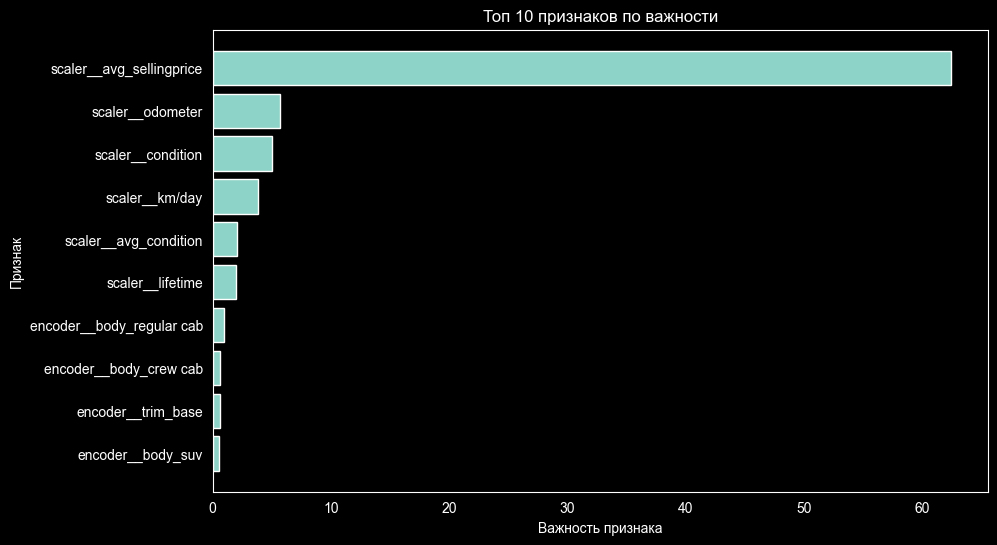

In [150]:

feature_importance = model.named_steps['cbr'].feature_importances_
feature_names = model.named_steps['ohe'].get_feature_names_out()
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Вывод важности признаков
top_n = 10  # Количество признаков для отображения
top_feature_names = sorted_feature_names[:top_n]
top_feature_importance = sorted_feature_importance[:top_n]
top_imp =pd.Series(top_feature_importance, index=top_feature_names).sort_values()

# Создание графика
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_imp, align='center')
plt.yticks(range(top_n), top_imp.index)
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Топ 10 признаков по важности')
plt.show()

# Финалочка

In [151]:
predicted_data.to_csv('predicted_data.csv',index=False)